<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

###  Feature Engineering, Regression, and Regularization

---

The application of machine learning to home pricing is a burgeoning field. Companies like OpenDoor are taking on the historically insular and unscientific real estate sales market by applying data science to better predict trends, detect patterns, and ultimately undercut the competition. 

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). The housing data available in this project has around 80 different variables cataloguing a wide variety of attributes for real estate properties. The target variable of interest is the sales price.

What has the most impact on the sales price of a house? Is just using square footage and building age sufficient, or are there other less obvious factors at play? You'll get to investigate what's important using EDA and regularized regression models, and practice model evaluation and cross-validation.

---

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Load the `housing.csv` dataset

---

The csv is located in the `DSI-SF-4/datasets/housing_regression` folder in your repo. 

**There is a file describing the columns in the dataset in the `data_description.txt` file in the same folder that contains the information on what the variables represent.**


In [131]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math as math

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [132]:
house = pd.read_csv('../../../DSI-SF-4/datasets/housing_regression/housing.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Examine the `SalePrice` variable

---

### 2.1 Plot the distribution of the `SalesPrice` variable and describe it with pandas

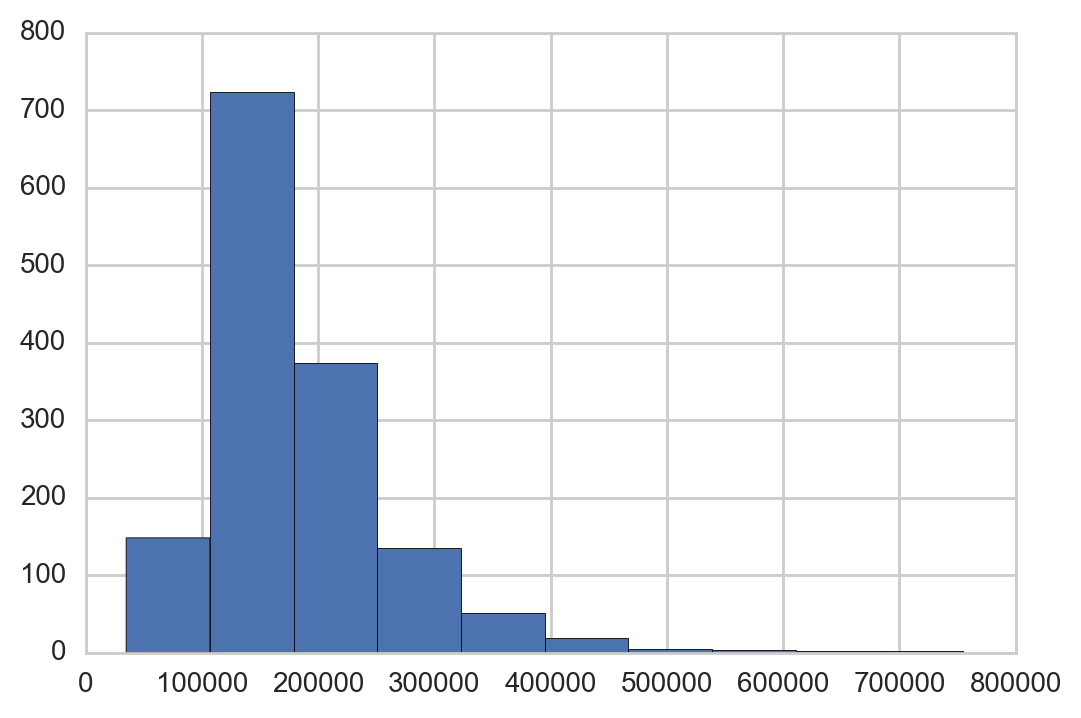

In [133]:
house['SalePrice'].hist()

### 2.2 Create a transformed version of the `SalesPrice` variable that makes it more normally distributed

Two common transformations to deal with long tails are taking the square root and taking the log of a variable. 

Plot the transformed variable.

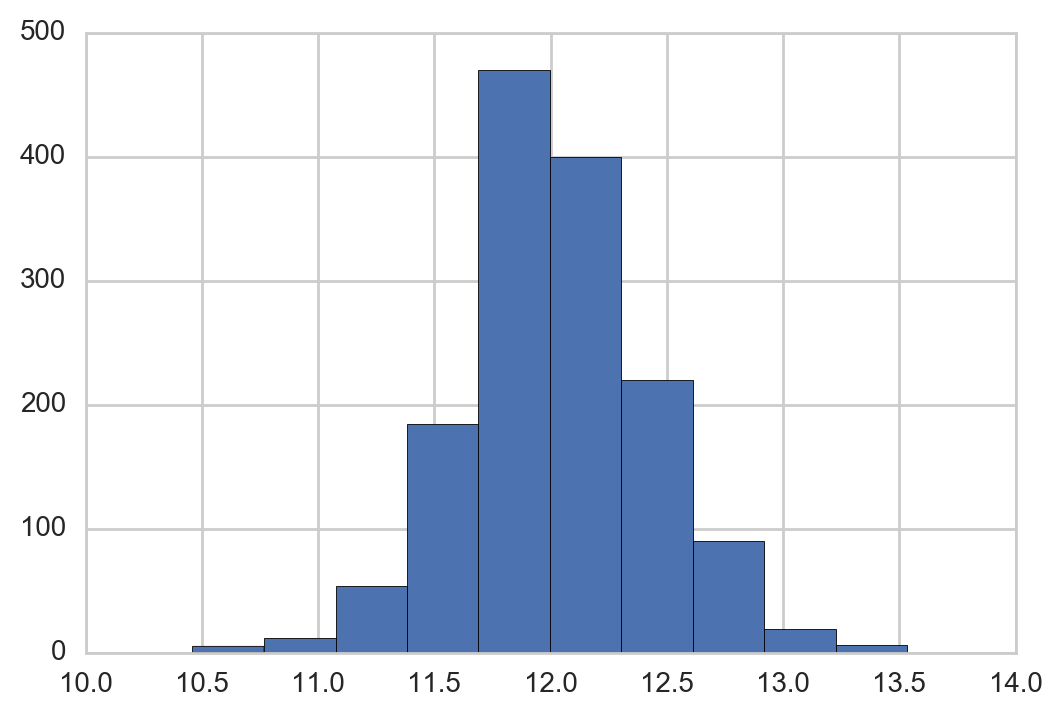

In [134]:
#Log
SalesPrice_log = house['SalePrice'].map(lambda x: math.log(x))
SalesPrice_log.hist()

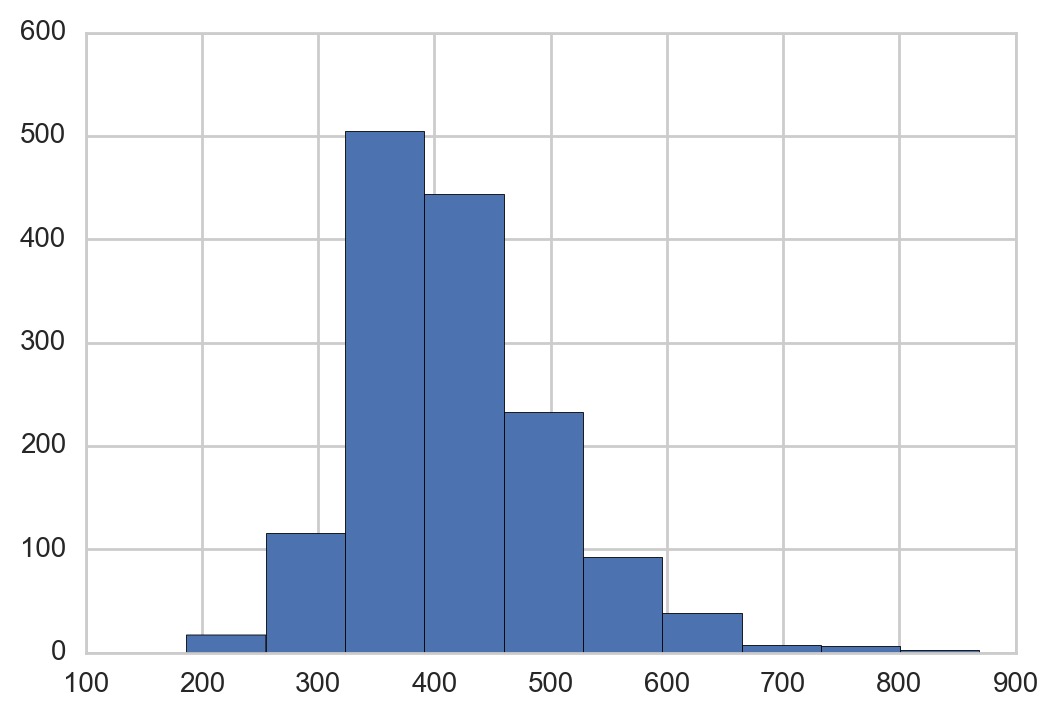

In [135]:
#SQRT
SalesPrice_sqrt = house['SalePrice'].map(lambda x: math.sqrt(x))
SalesPrice_sqrt.hist()

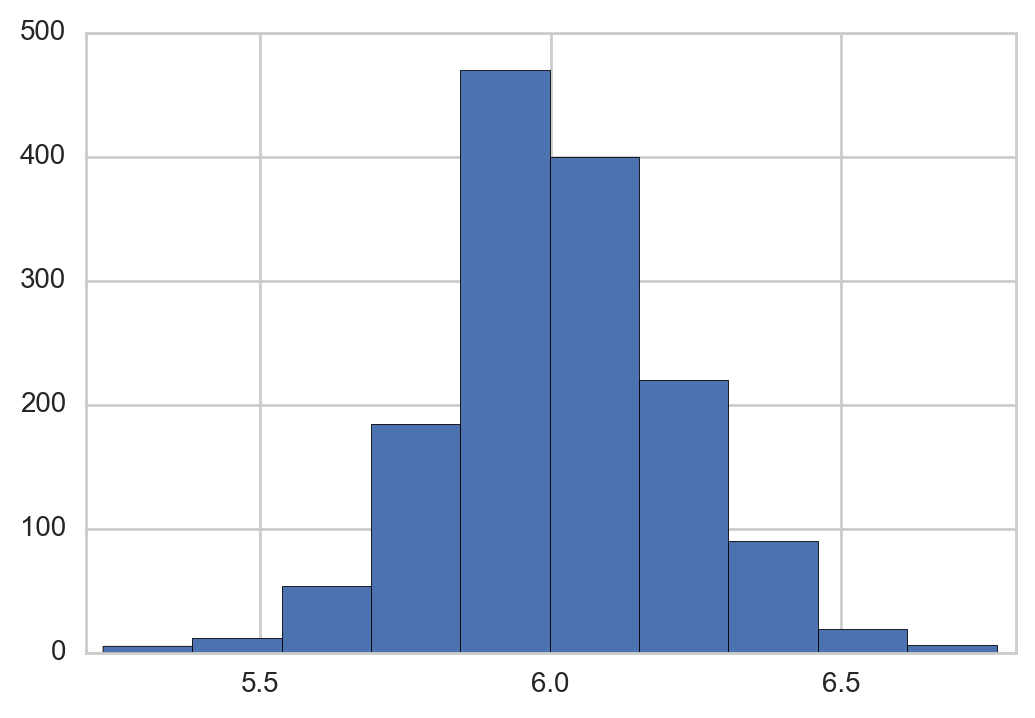

In [136]:
#Both
SalesPrice_both = house['SalePrice'].map(lambda x: math.log(math.sqrt(x)))
SalesPrice_both.hist()

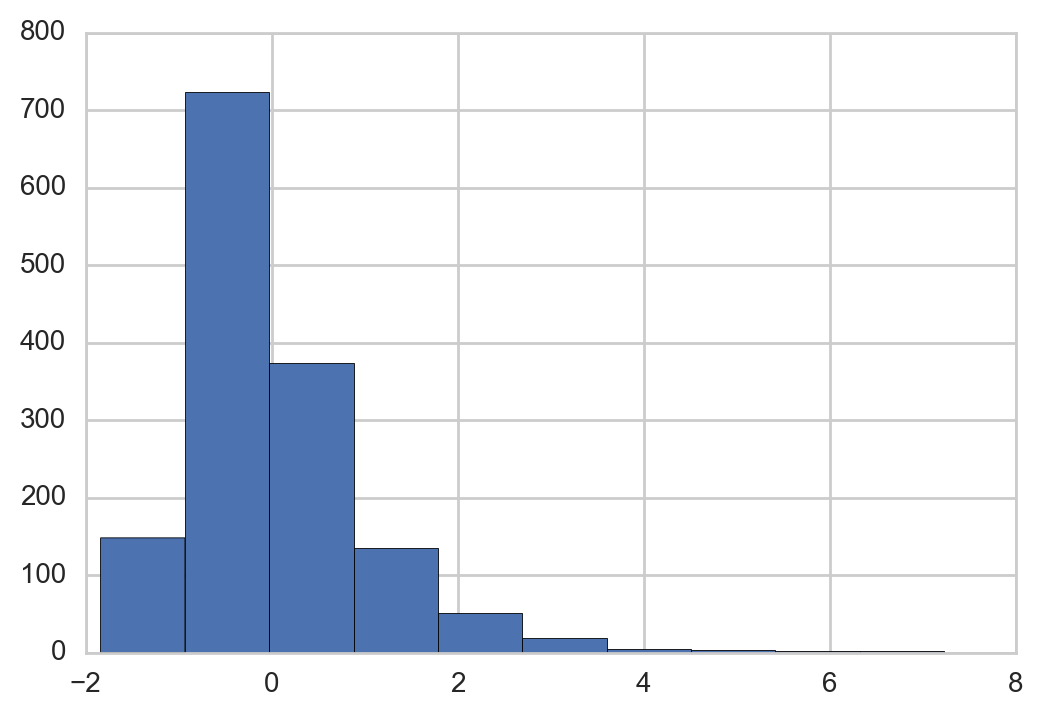

In [137]:
#Normalized
SalePrice_norm = (house['SalePrice'] - np.mean(house['SalePrice']))/np.std(house['SalePrice'])
SalePrice_norm.hist()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Correlations with sale price

---

### 3.1 Correlate the age of a house when sold with the sale price

How is the correlation different when using the original and transformed sale price?


In [138]:
house['House_Age'] = house['YrSold'] - house['YearBuilt'] 

house[['SalePrice', 'House_Age']].corr()

,SalePrice,House_Age
SalePrice,1.00000,-0.52335
House_Age,-0.52335,1.00000


In [139]:
house['New_SalePrice'] = SalesPrice_both
house[['New_SalePrice', 'House_Age']].corr()

,New_SalePrice,House_Age
New_SalePrice,1.00000,-0.58729
House_Age,-0.58729,1.00000


### 3.2 Plot the age of the house at sale against the sale price variables

How does it differ between the original and transformed variables? What do the charts indicate about the relationship between the variables?

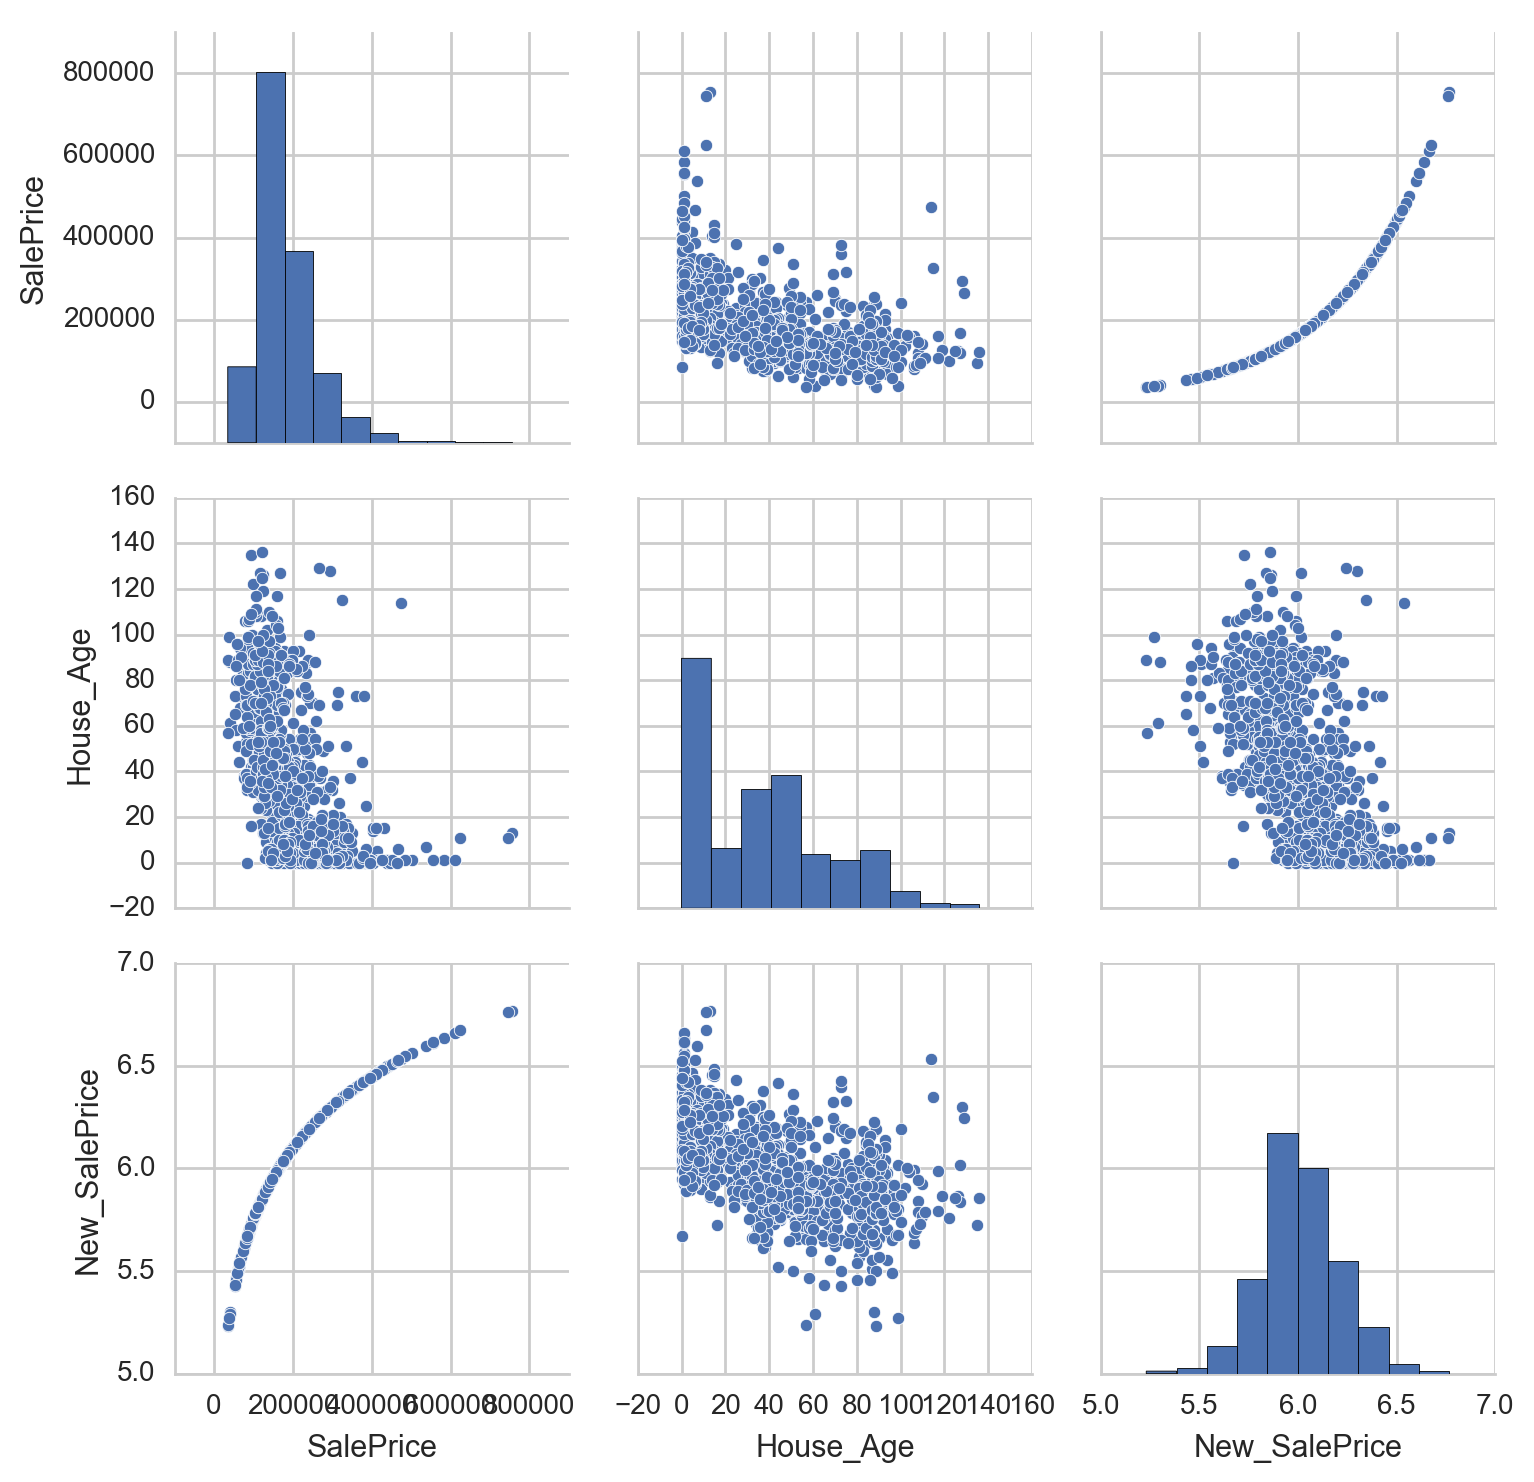

In [140]:
temp = house[['SalePrice','House_Age', 'New_SalePrice']]
sns.pairplot(temp)

### 3.3 Visually compare price to total livable square feet, `GrLivArea`

What is the relationship, if any?

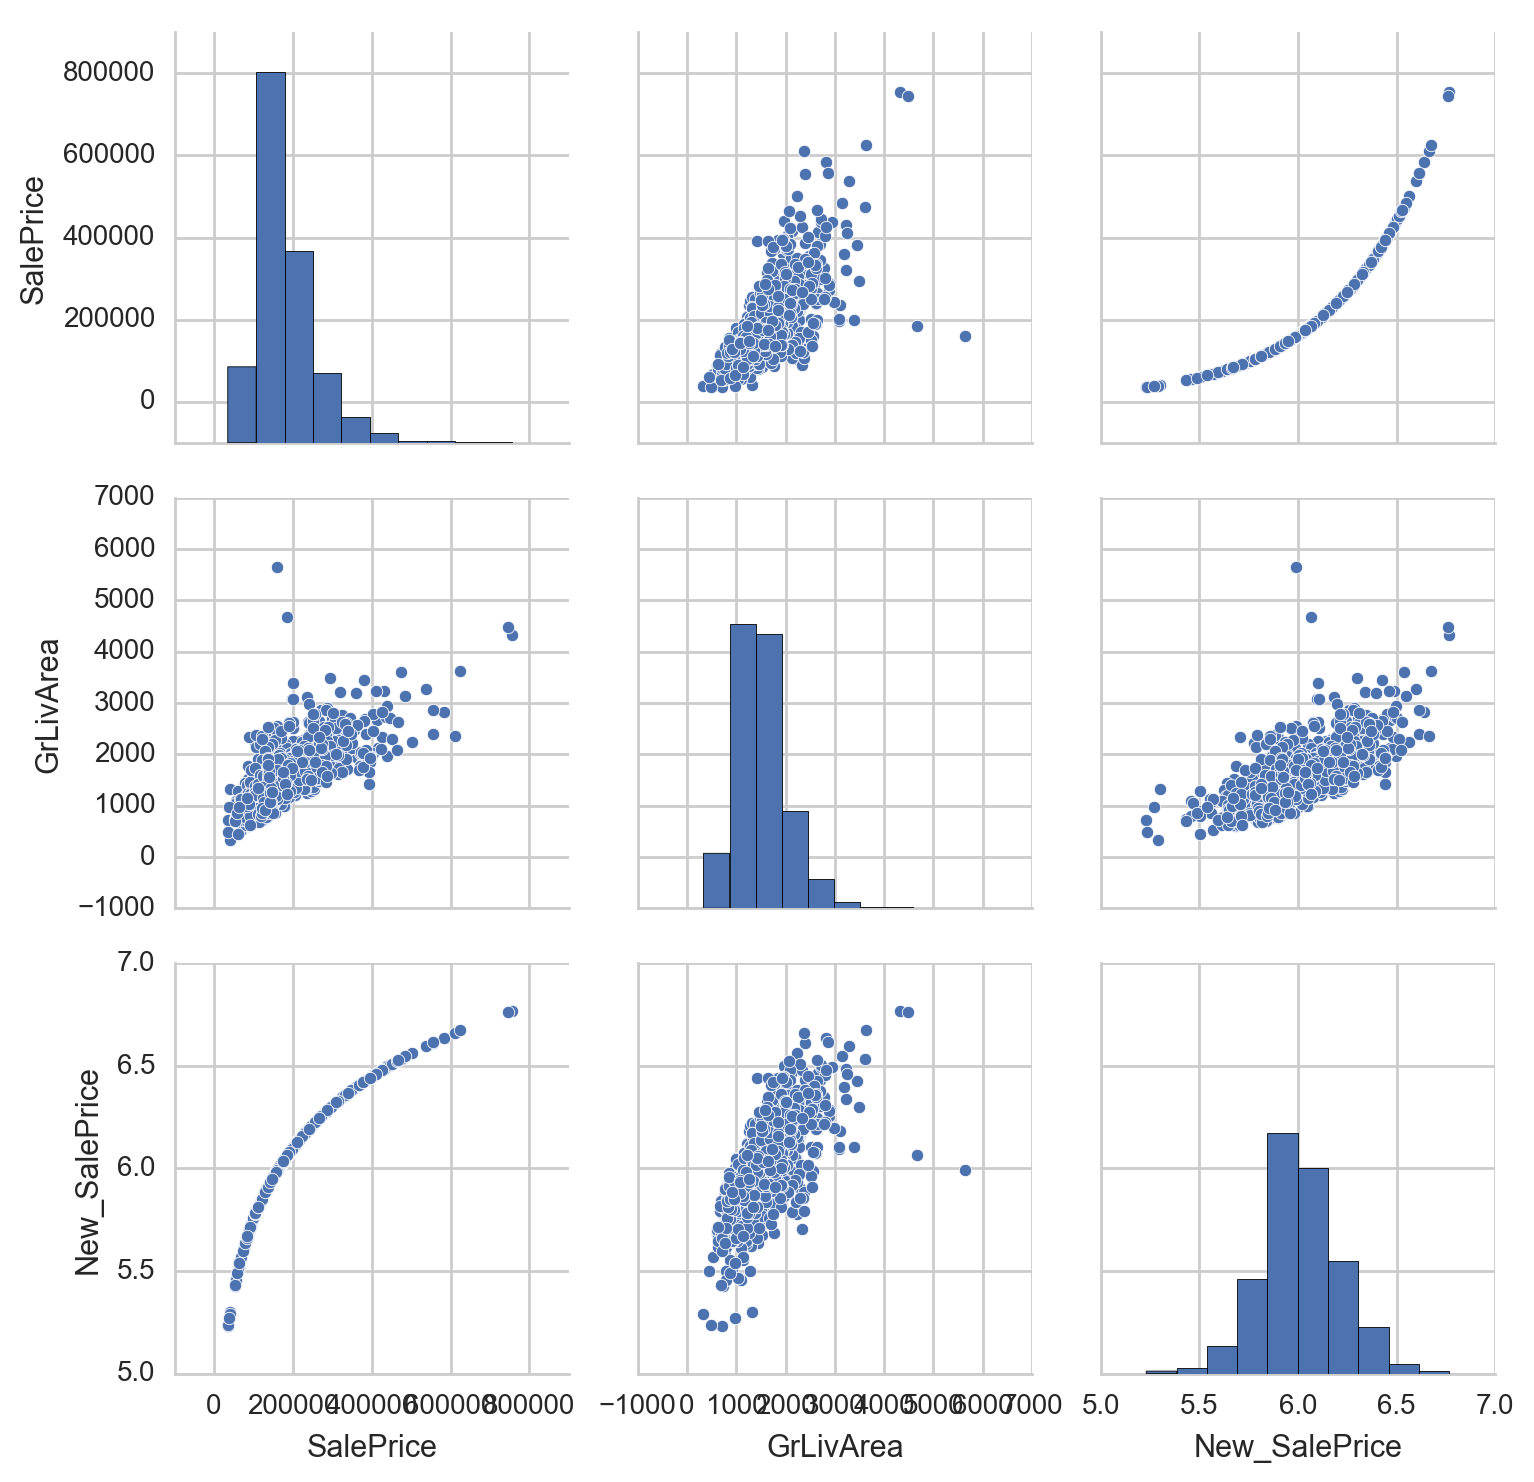

In [141]:
sns.pairplot(house[['SalePrice','GrLivArea', 'New_SalePrice']])

### 3.4 Plot and describe the relationship between two continuous variables of your choice in the data

Why did you choose those variables? What is the relationship that the chart sbows, if any?

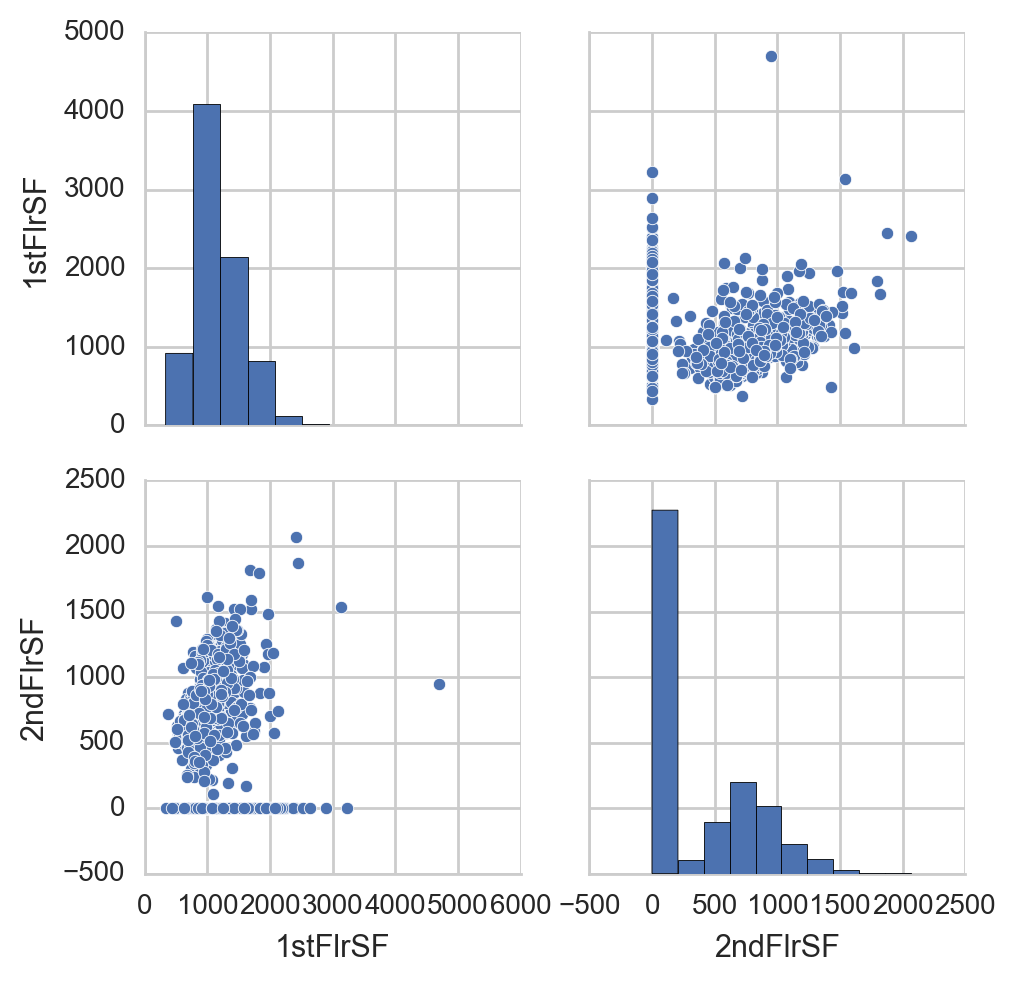

In [142]:
sns.pairplot(house[['1stFlrSF', '2ndFlrSF']])

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Data transformation and quality assessment

---

**Note: from this point onward, you can use your transformed price variable or the original price variable. Up to you. It will change the interpretation of the coefficients in your model.**

### 4.1 Restrict the data 

Only keep houses that are residential (remove the commercial code buildings).

In [143]:
print house['MSZoning'].unique()
house.shape

['RL' 'RM' 'C (all)' 'FV' 'RH']


(1460, 83)

In [144]:
residential_mask = (house['MSZoning'] != 'C (all)')
house_cleaned = house[residential_mask]
house_cleaned.shape
house_cleaned.head()
print house.shape, house_cleaned.shape

(1460, 83) (1450, 83)


### 4.2 Handle null values in the dataset

Many of the variables contain null values. In many of these cases the null value is actually representative of a category that is a level of a categorical variable.

Eliminate the null values from your dataset, explaining your rationale for each variable. You have options for null values:

- Replace the null values (impute).
- Drop the observation.
- Drop the variable. 

In [145]:
#Looked at the data_description file to see which variables had "nan" or "NA" as viable answers/represented a value
house_cleaned['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [146]:
house_cleaned.shape

(1450, 83)

In [147]:
#house_cleaned.isnull().sum().unique()

null_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'FireplaceQu', 'GarageType', 'GarageFinish','GarageQual', 'GarageCond', 'PoolQC',
             'Fence', 'MiscFeature']
temp_df = house_cleaned.loc[:,house_cleaned.columns.difference(null_vars)]

temp_mask = temp_df.isnull().sum().sort_values(ascending=False)
#Removed the following null values that are not part of the intrensiv value. I also felt these fields were very
#specific about the house the either owners would not look into or would renovate when they purchased the house

house_cleaned_temp = house_cleaned.drop(['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'MasVnrType', 'Electrical'], axis=1)
#house_cleaned.isnull().sum().sort_values(ascending=False)




In [148]:
house_cleaned_temp.shape

(1450, 78)

In [149]:
house_cleaned_temp.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,House_Age,New_SalePrice
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,0,2,2008,WD,Normal,208500,5,6.123847
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,0,5,2007,WD,Normal,181500,31,6.054505
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,0,9,2008,WD,Normal,223500,7,6.158583
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,0,2,2006,WD,Abnorml,140000,91,5.924699
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,0,12,2008,WD,Normal,250000,8,6.214608


### 4.3 Remove any variables you think are not viable to use as predictors of price.

This can be a subjective process. A common criterion is to remove variables that have little to no variance. This would be, for example, a  variable where nearly all observations were in a single category or had a single value. 

For each variable you remove (if any), explain your rationale for why.

In [150]:
#np.var(house_cleaned).sort_values(ascending=True)

#columns to remove when looking at the variance:
#OverallCond, OverallQual - these are subjective metrics that won't give any insight into the actual quality of the house
#New_SalesPrice - because I'm going to use the original salesprice
#KitchenAbvGr, BedroomAbvGr, TotRmsAbvGrd - small metrics that don't help identify unique aspects of the house

In [151]:
house_cleaned_temp.drop(['OverallCond', 'OverallQual', 'New_SalePrice', 'KitchenAbvGr', 'BedroomAbvGr', 'TotRmsAbvGrd'], axis=1, inplace=True)

In [152]:
house_cleaned_temp.shape

(1450, 72)

In [153]:
house_updated = house_cleaned_temp
#house_updated.info()
house_updated.shape
house_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 72 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-null object
ExterQual        1450 non-null object
ExterCond        1450 non-

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. Plot a correlation matrix between the continuous variables

---

**Some columns in the DataFrame are numeric type, but that doesn't necessarily mean that they are continuous. Sometimes numeric values are used to represent the levels of a categorical variable.**

To plot a correlation matrix, it is popular to represent the correlation values using hue with a "heatmap". Look up how to plot a heatmap of a correlation matrix in python and show it below. Make sure that the variable labels are clear on the axes.

Describe anything interesting or notable you observe from the correlation matrix.

In [154]:
house_updated['SalePrice'] = house_updated['SalePrice'].apply(float)
house_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 72 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-null object
ExterQual        1450 non-null object
ExterCond        1450 non-

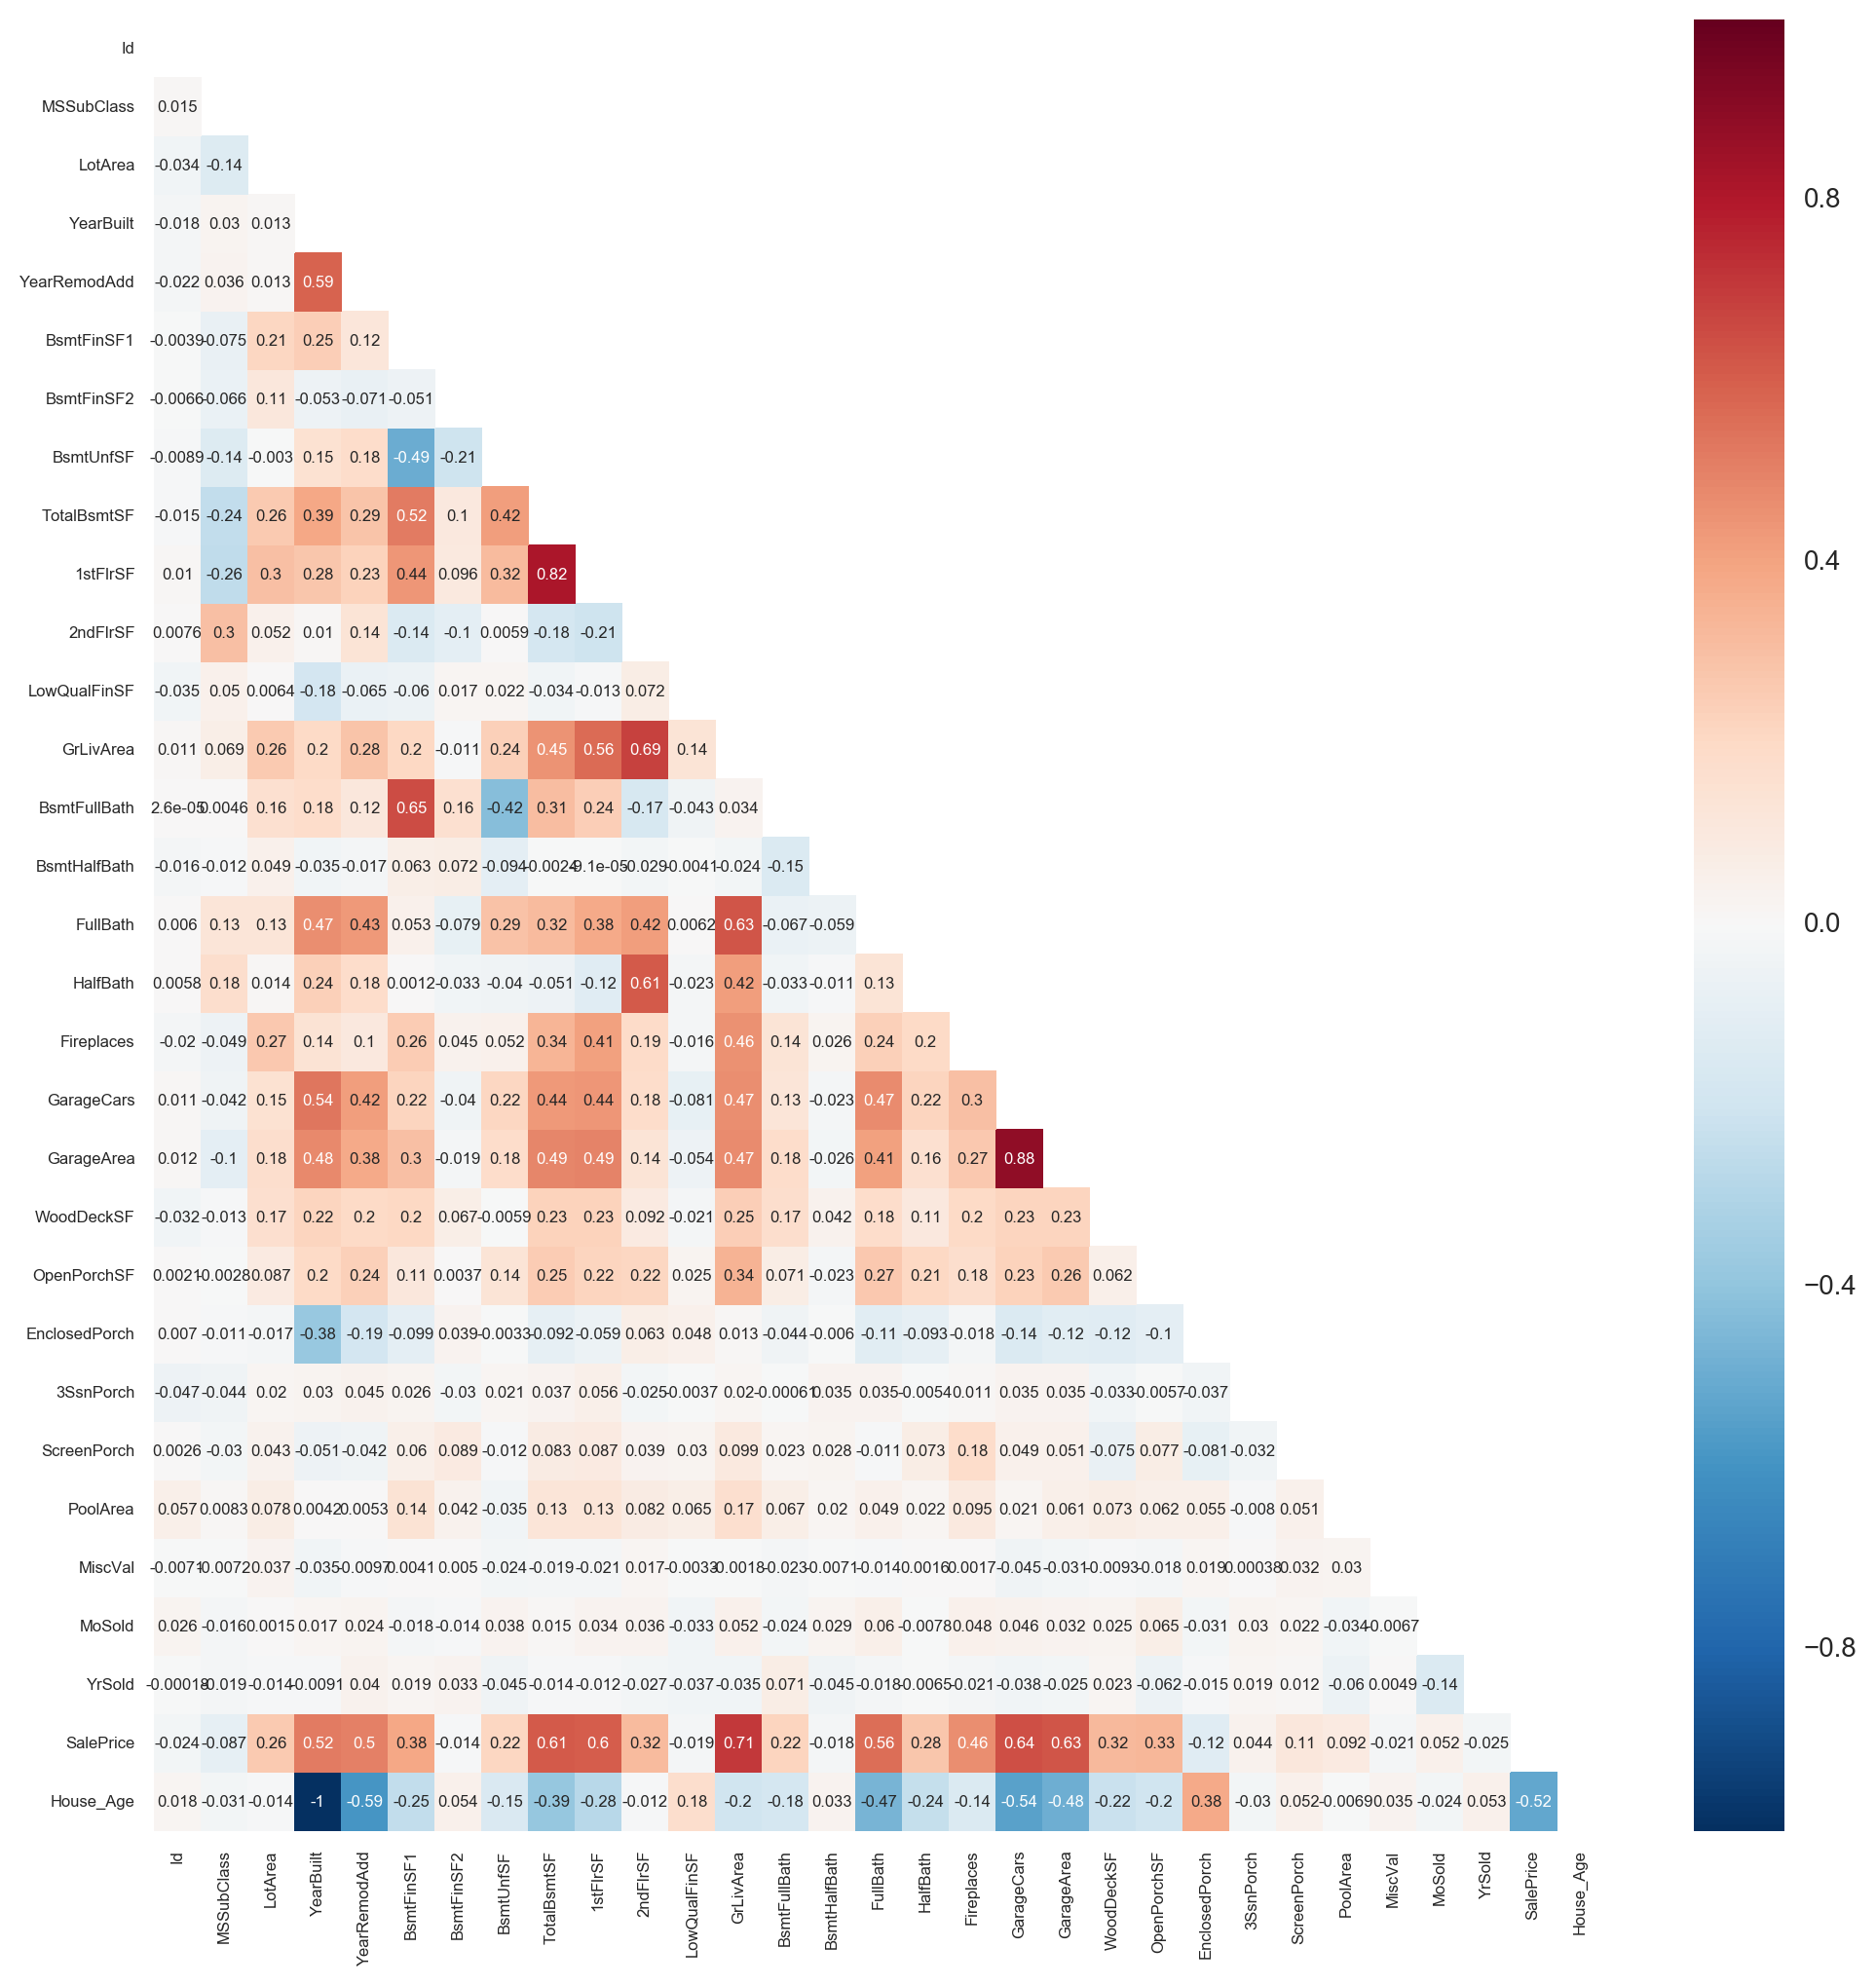

In [155]:
#Appears from the heatmap that there are alot of correlations between floors, garage space, bathrooms and selling price

def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, annot_kws={"size": 6})

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=6, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=6, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
correlation_heat_map(house_updated)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 6. Make boxplots of categorical variables against the sale price

---

You don't have to plot all of them unless you want to. Make at least 8 boxplots looking at the distribution of sale price across levels of categorical variables in your dataset. This can be whichever categorical variables interest you the most.

Write up a few findings on the relationship between sales price and the categorical variables you chose to plot. Anything surprising?

In [156]:
house_updated.shape

(1450, 72)

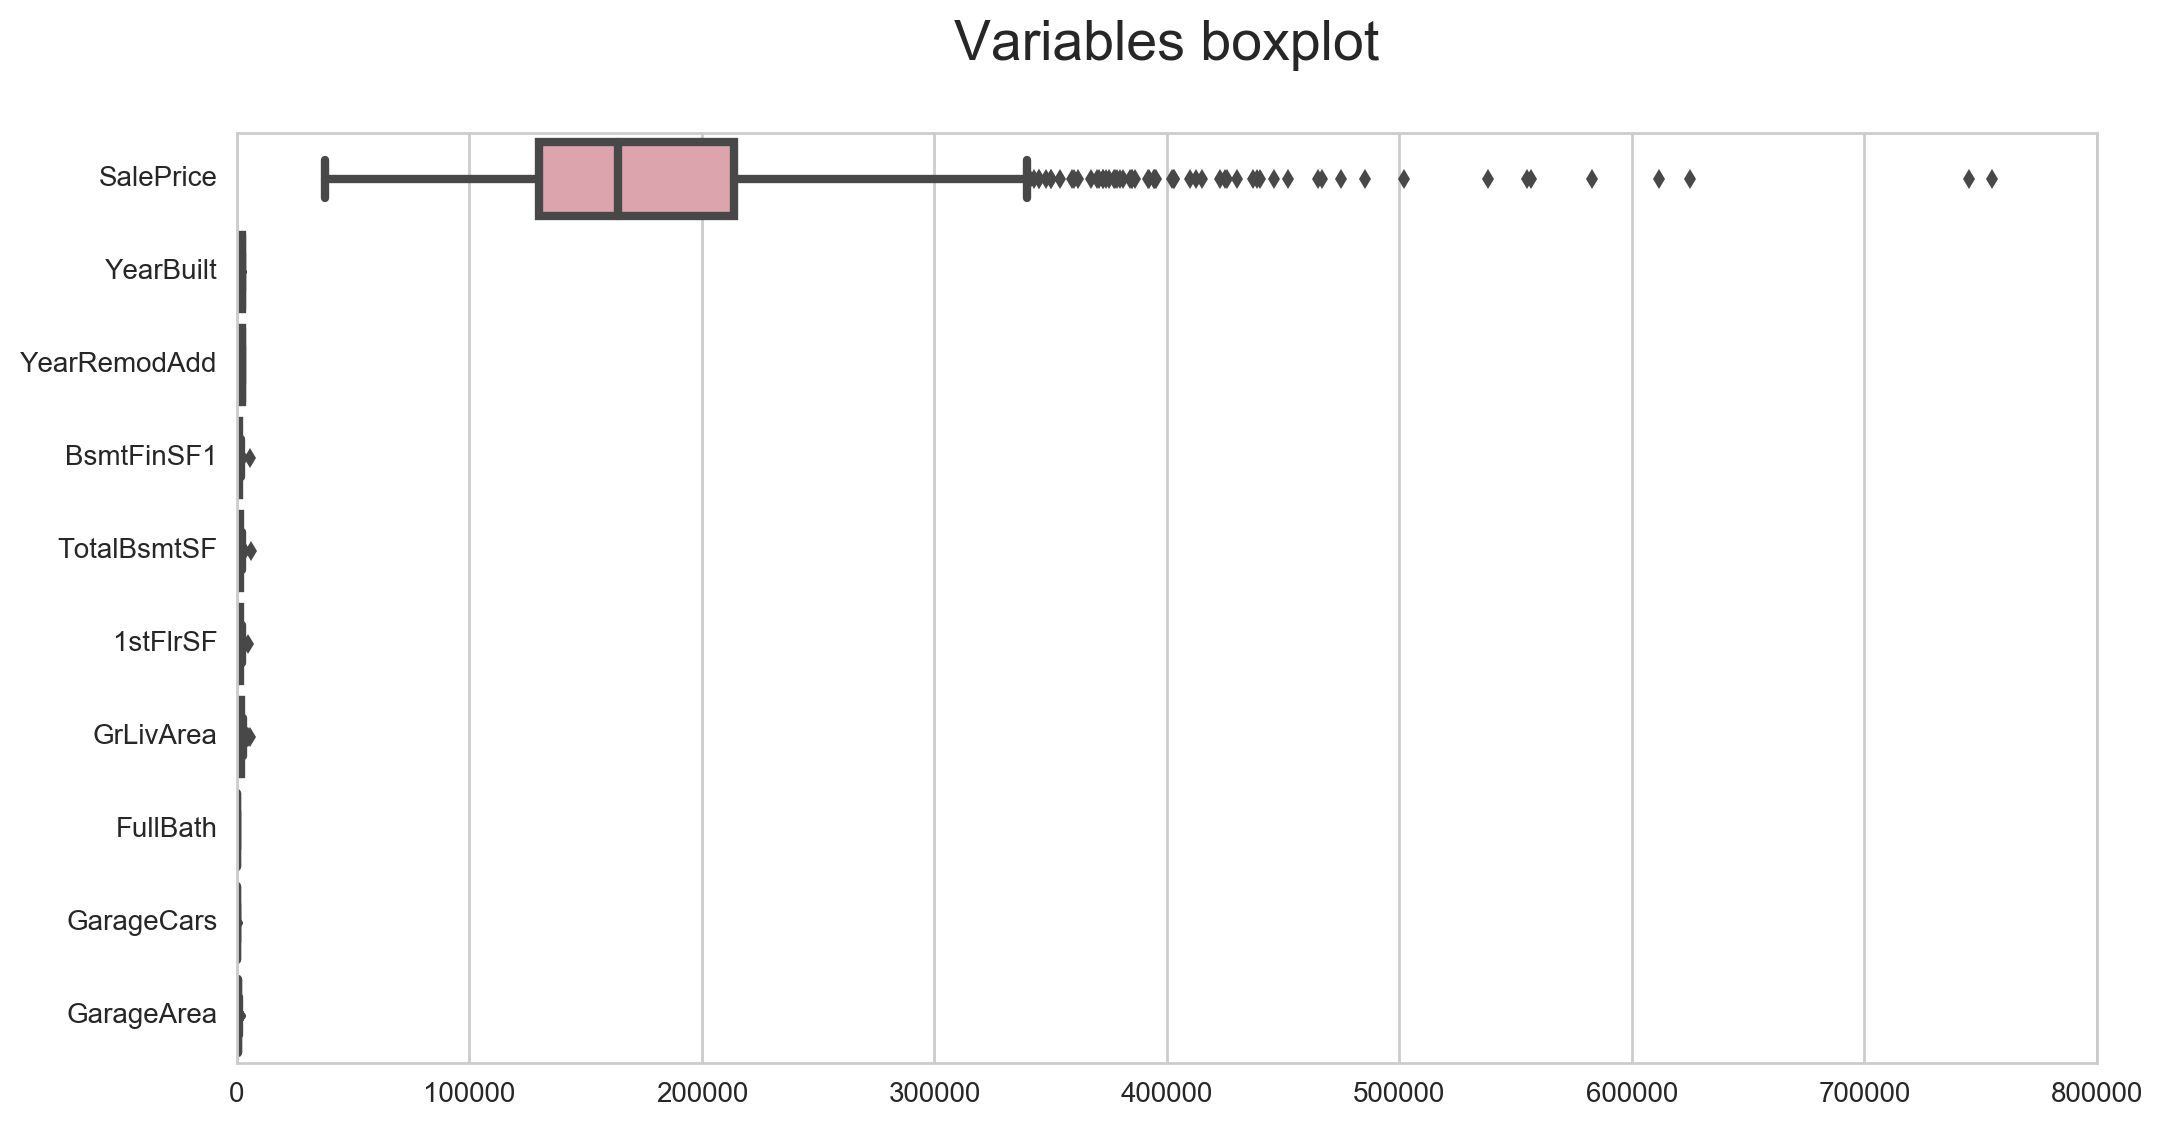

In [157]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(data=house_updated[['SalePrice', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'GarageCars', 'GarageArea']], orient='h', fliersize=5, linewidth=3, saturation=0.5)

ax.set_title('Variables boxplot\n', fontsize=20)
plt.show()

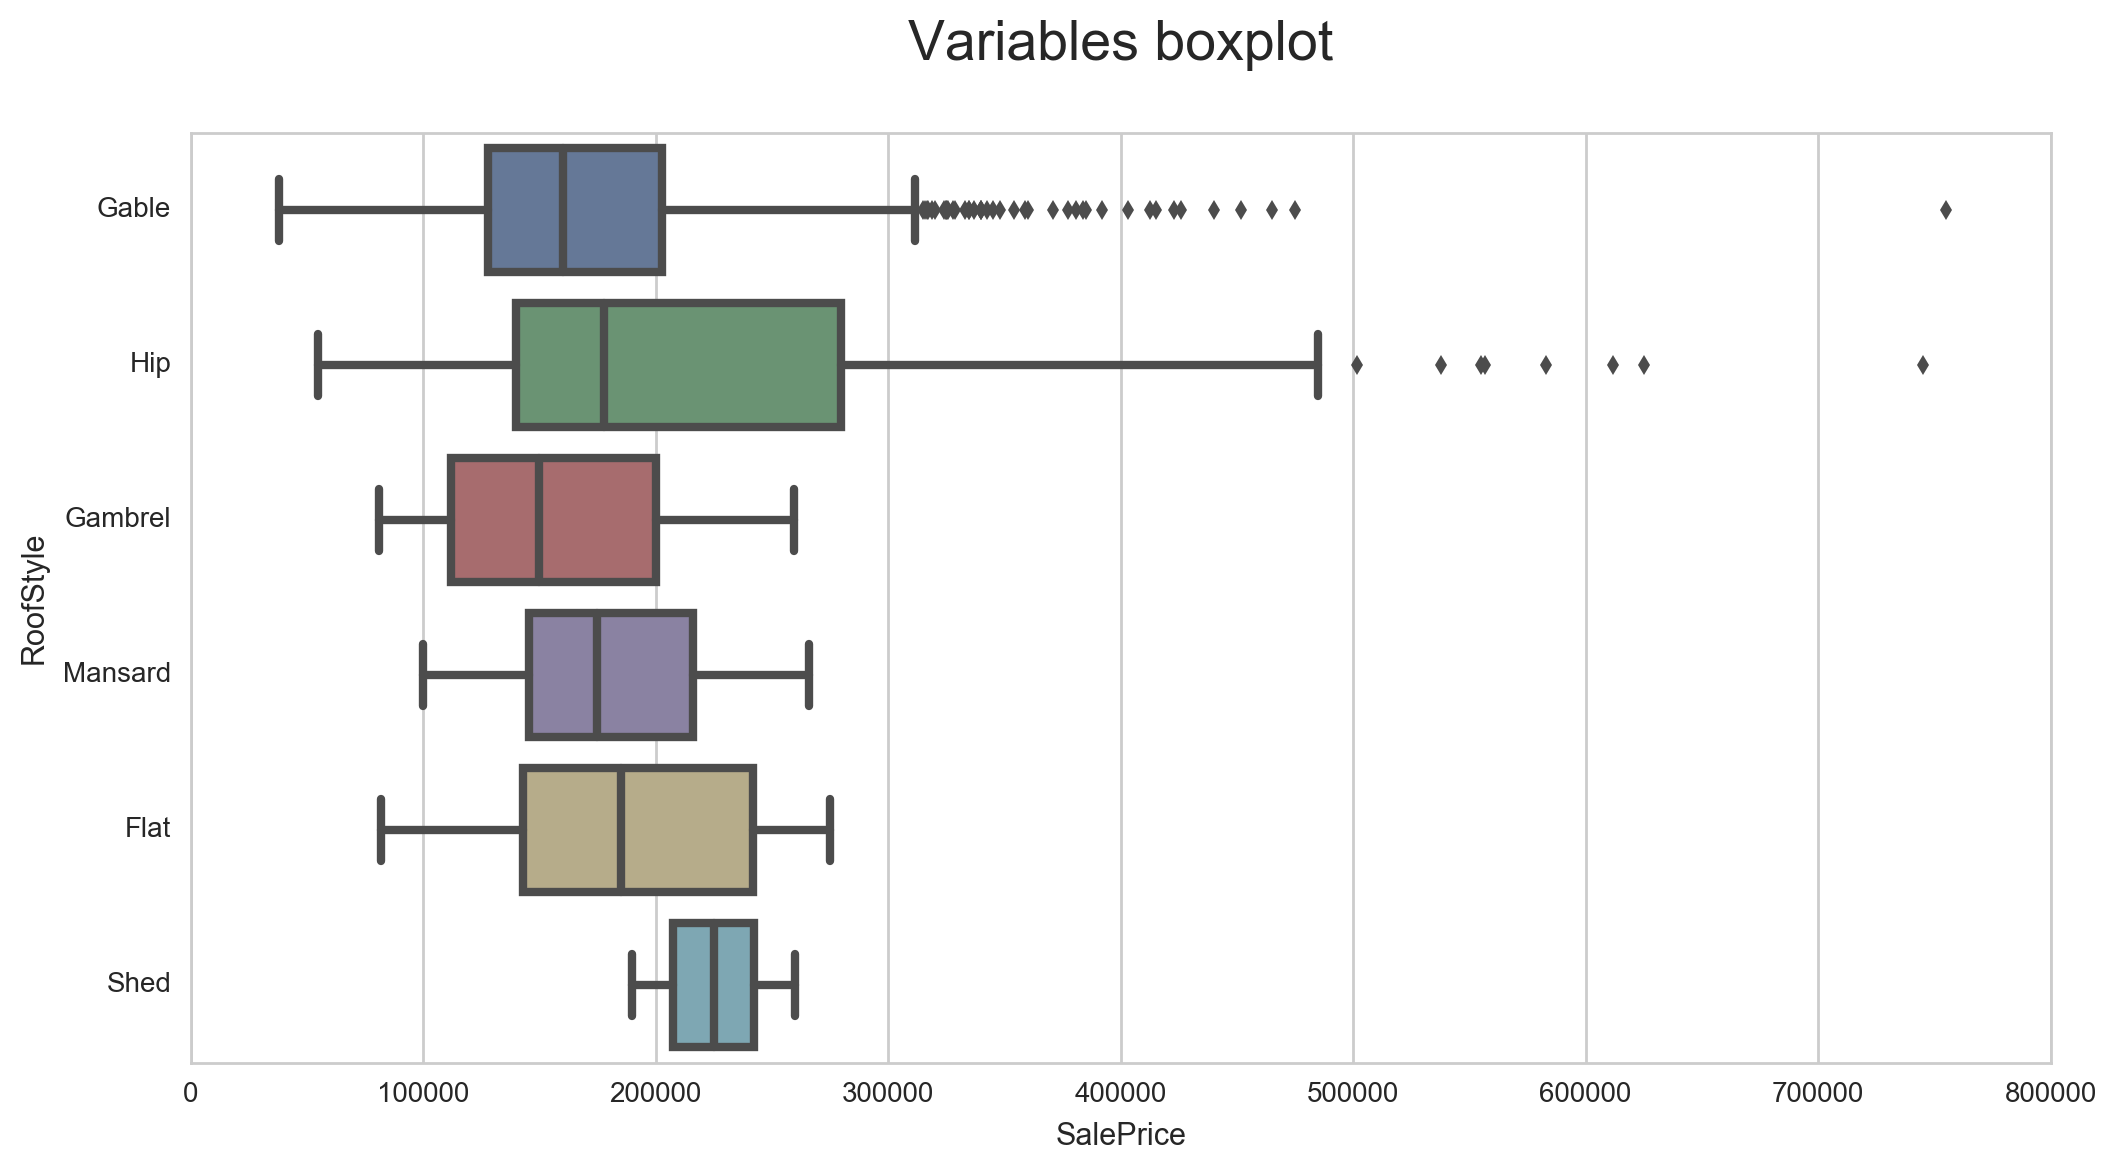

In [158]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=house_updated['SalePrice'], y=house_updated['RoofStyle'], orient='h', fliersize=5, linewidth=3, saturation=0.5)

ax.set_title('Variables boxplot\n', fontsize=20)
plt.show()

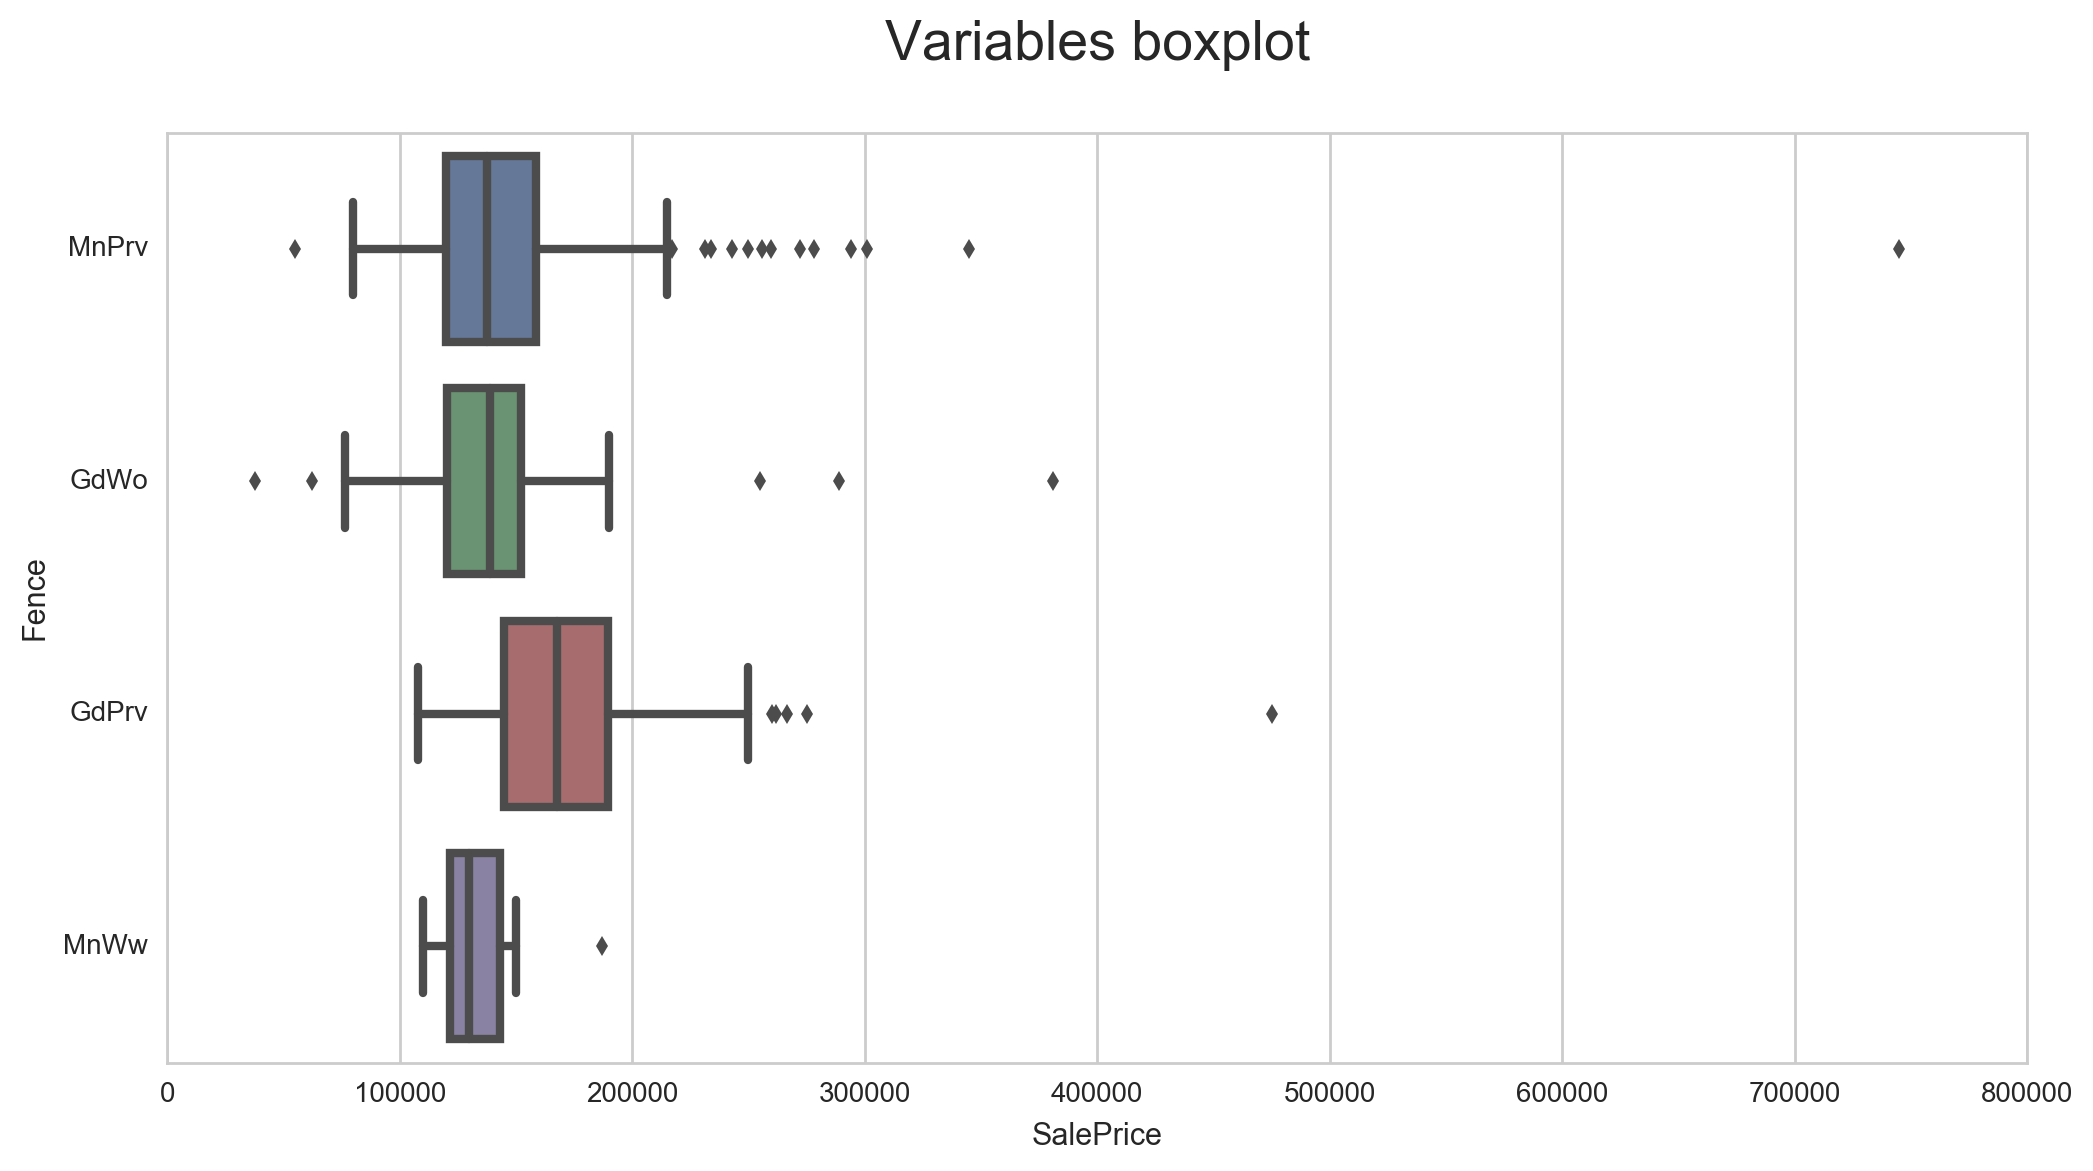

In [159]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=house_updated['SalePrice'], y=house_updated['Fence'], orient='h', fliersize=5, linewidth=3, saturation=0.5)

ax.set_title('Variables boxplot\n', fontsize=20)
plt.show()

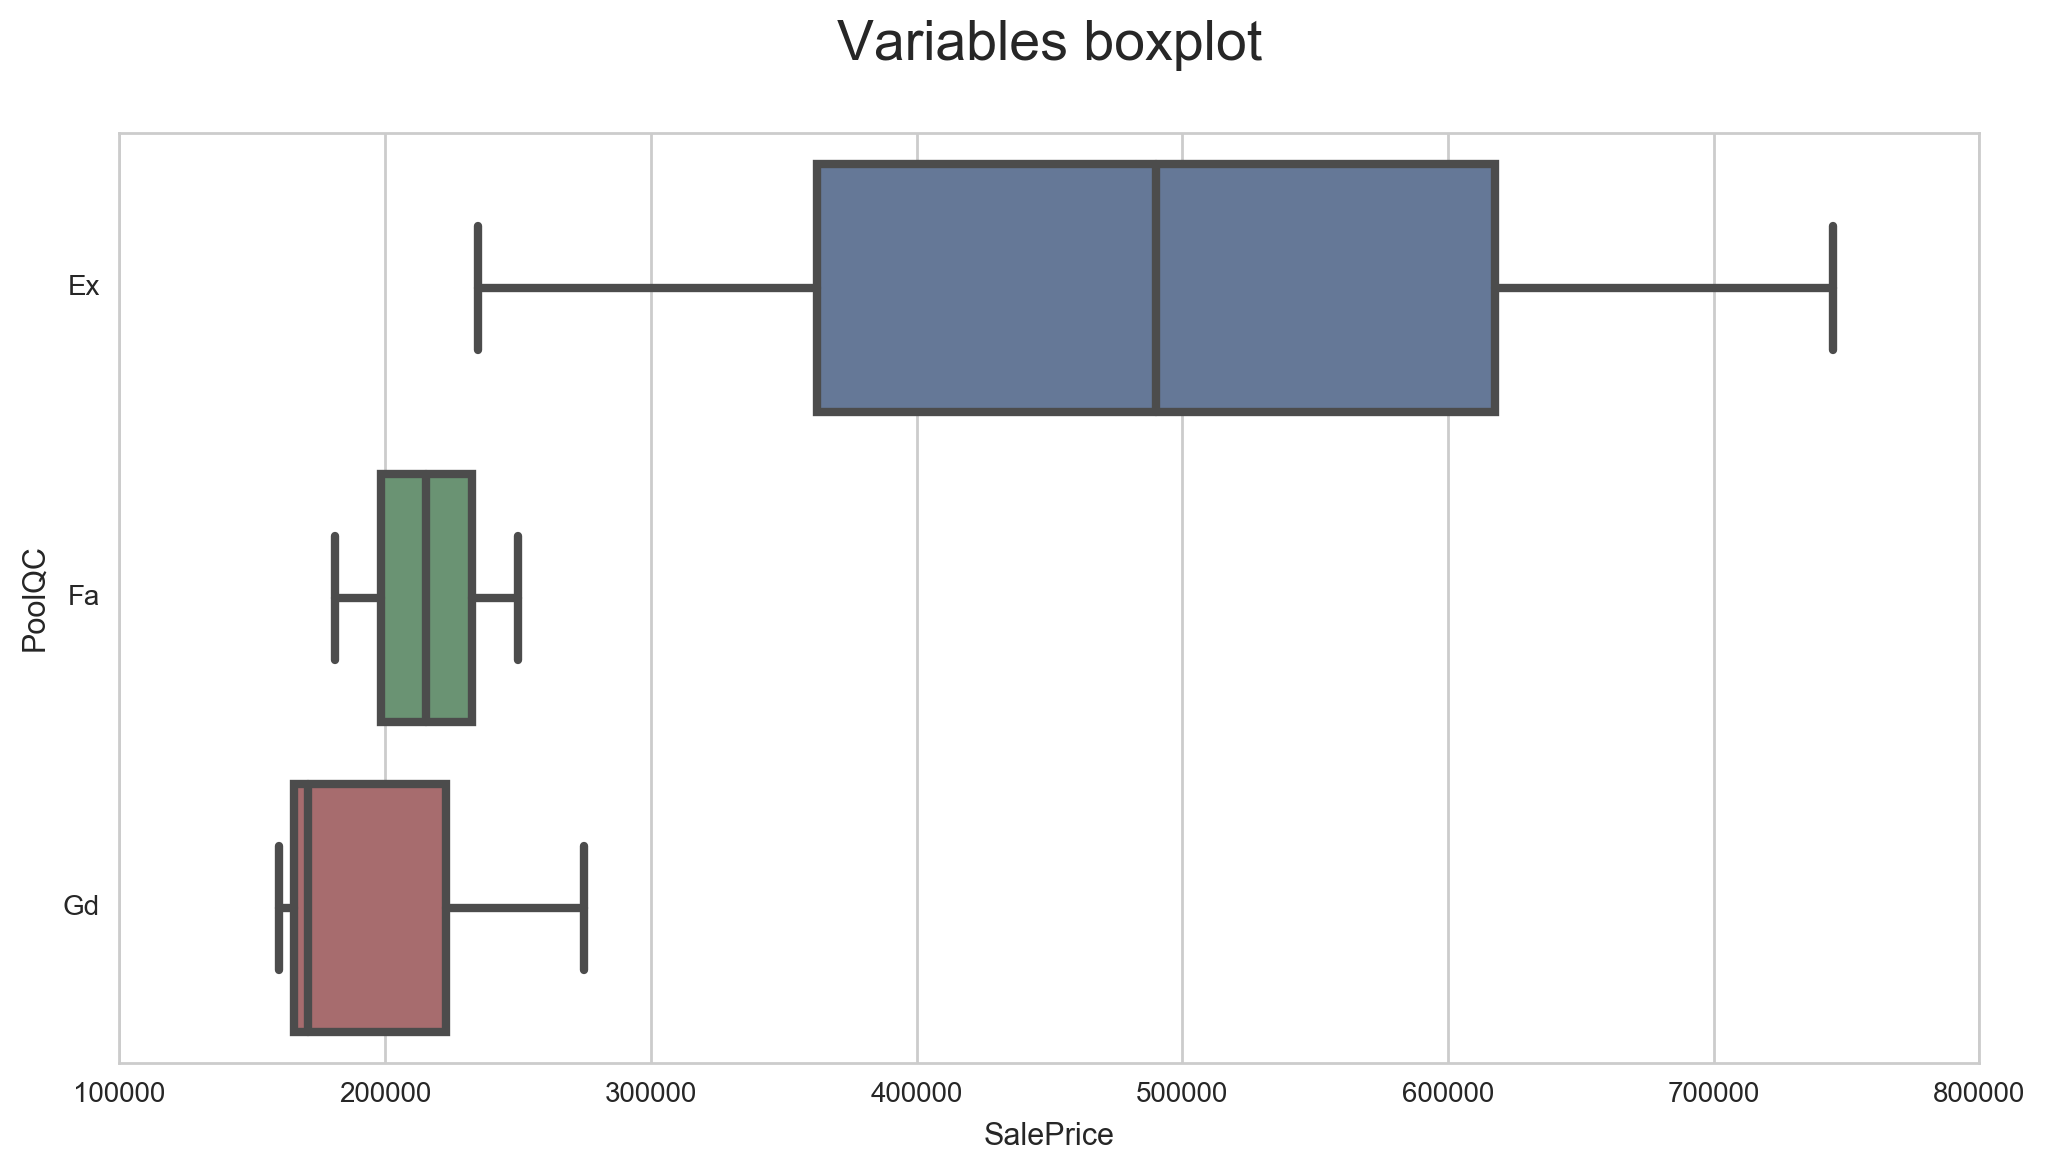

In [160]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=house_updated['SalePrice'], y=house_updated['PoolQC'], orient='h', fliersize=5, linewidth=3, saturation=0.5)

ax.set_title('Variables boxplot\n', fontsize=20)
plt.show()

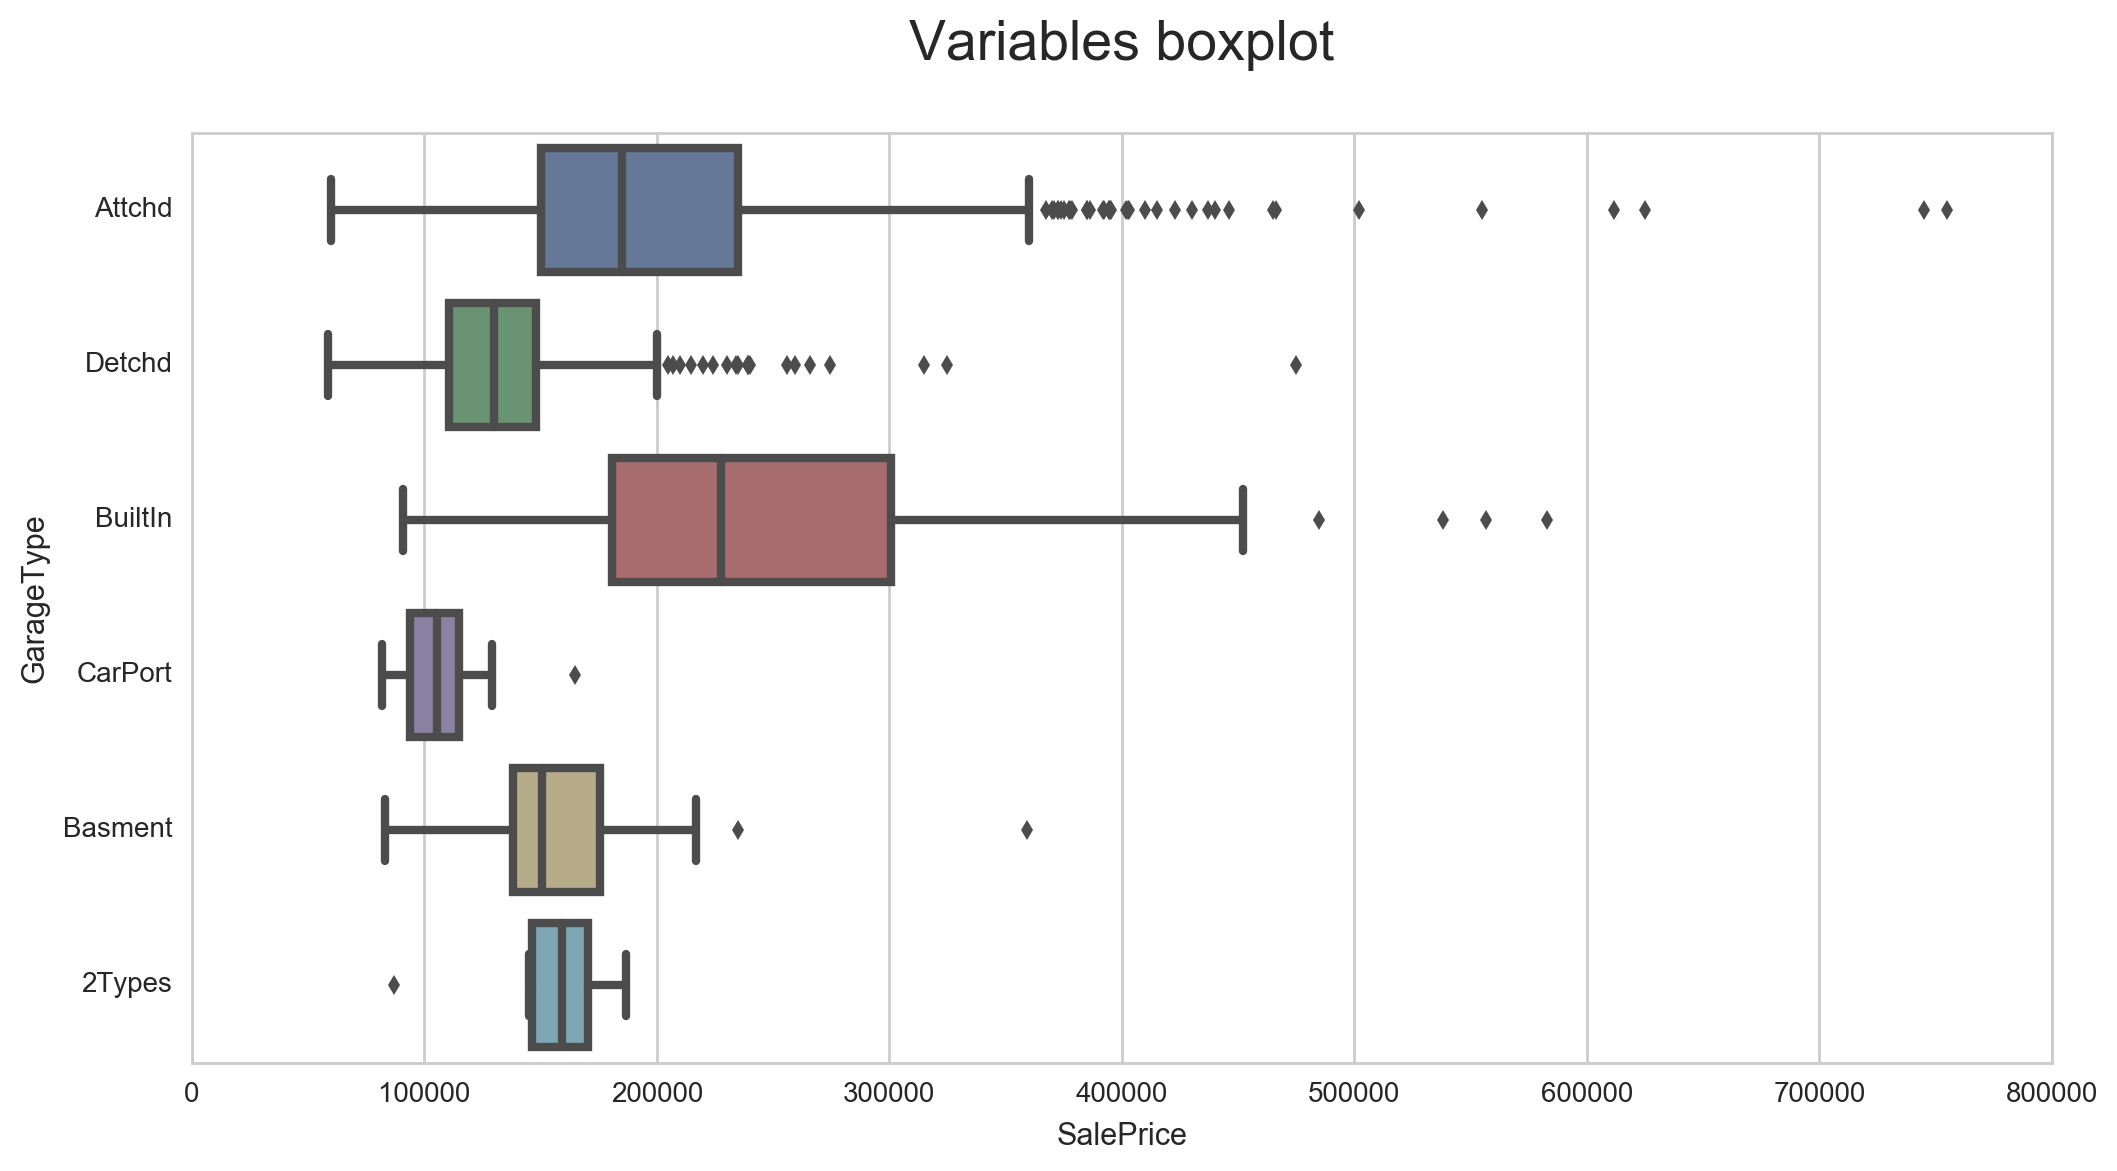

In [161]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=house_updated['SalePrice'], y=house_updated['GarageType'], orient='h', fliersize=5, linewidth=3, saturation=0.5)

ax.set_title('Variables boxplot\n', fontsize=20)
plt.show()

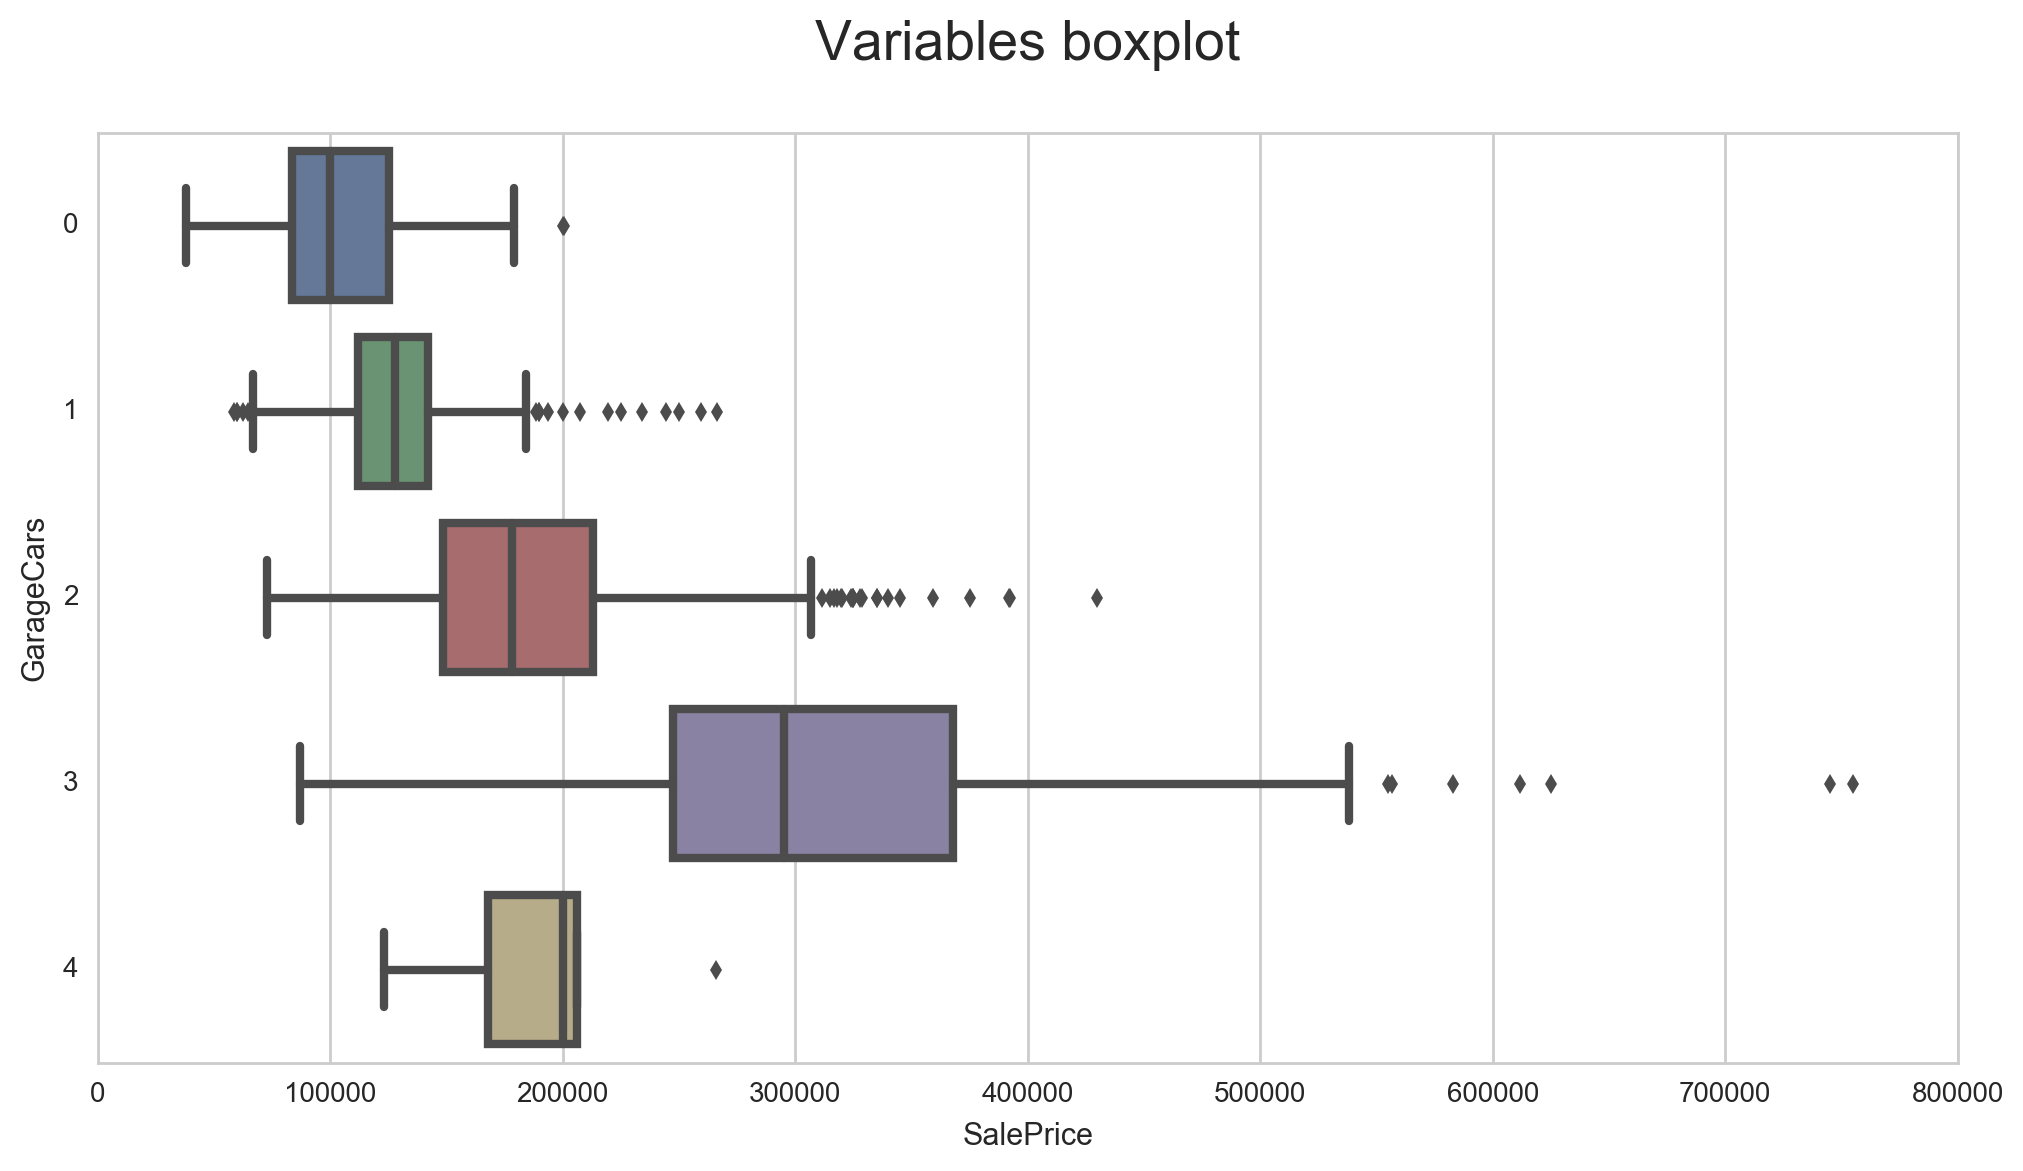

In [162]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=house_updated['SalePrice'], y=house_updated['GarageCars'], orient='h', fliersize=5, linewidth=3, saturation=0.5)

ax.set_title('Variables boxplot\n', fontsize=20)
plt.show()

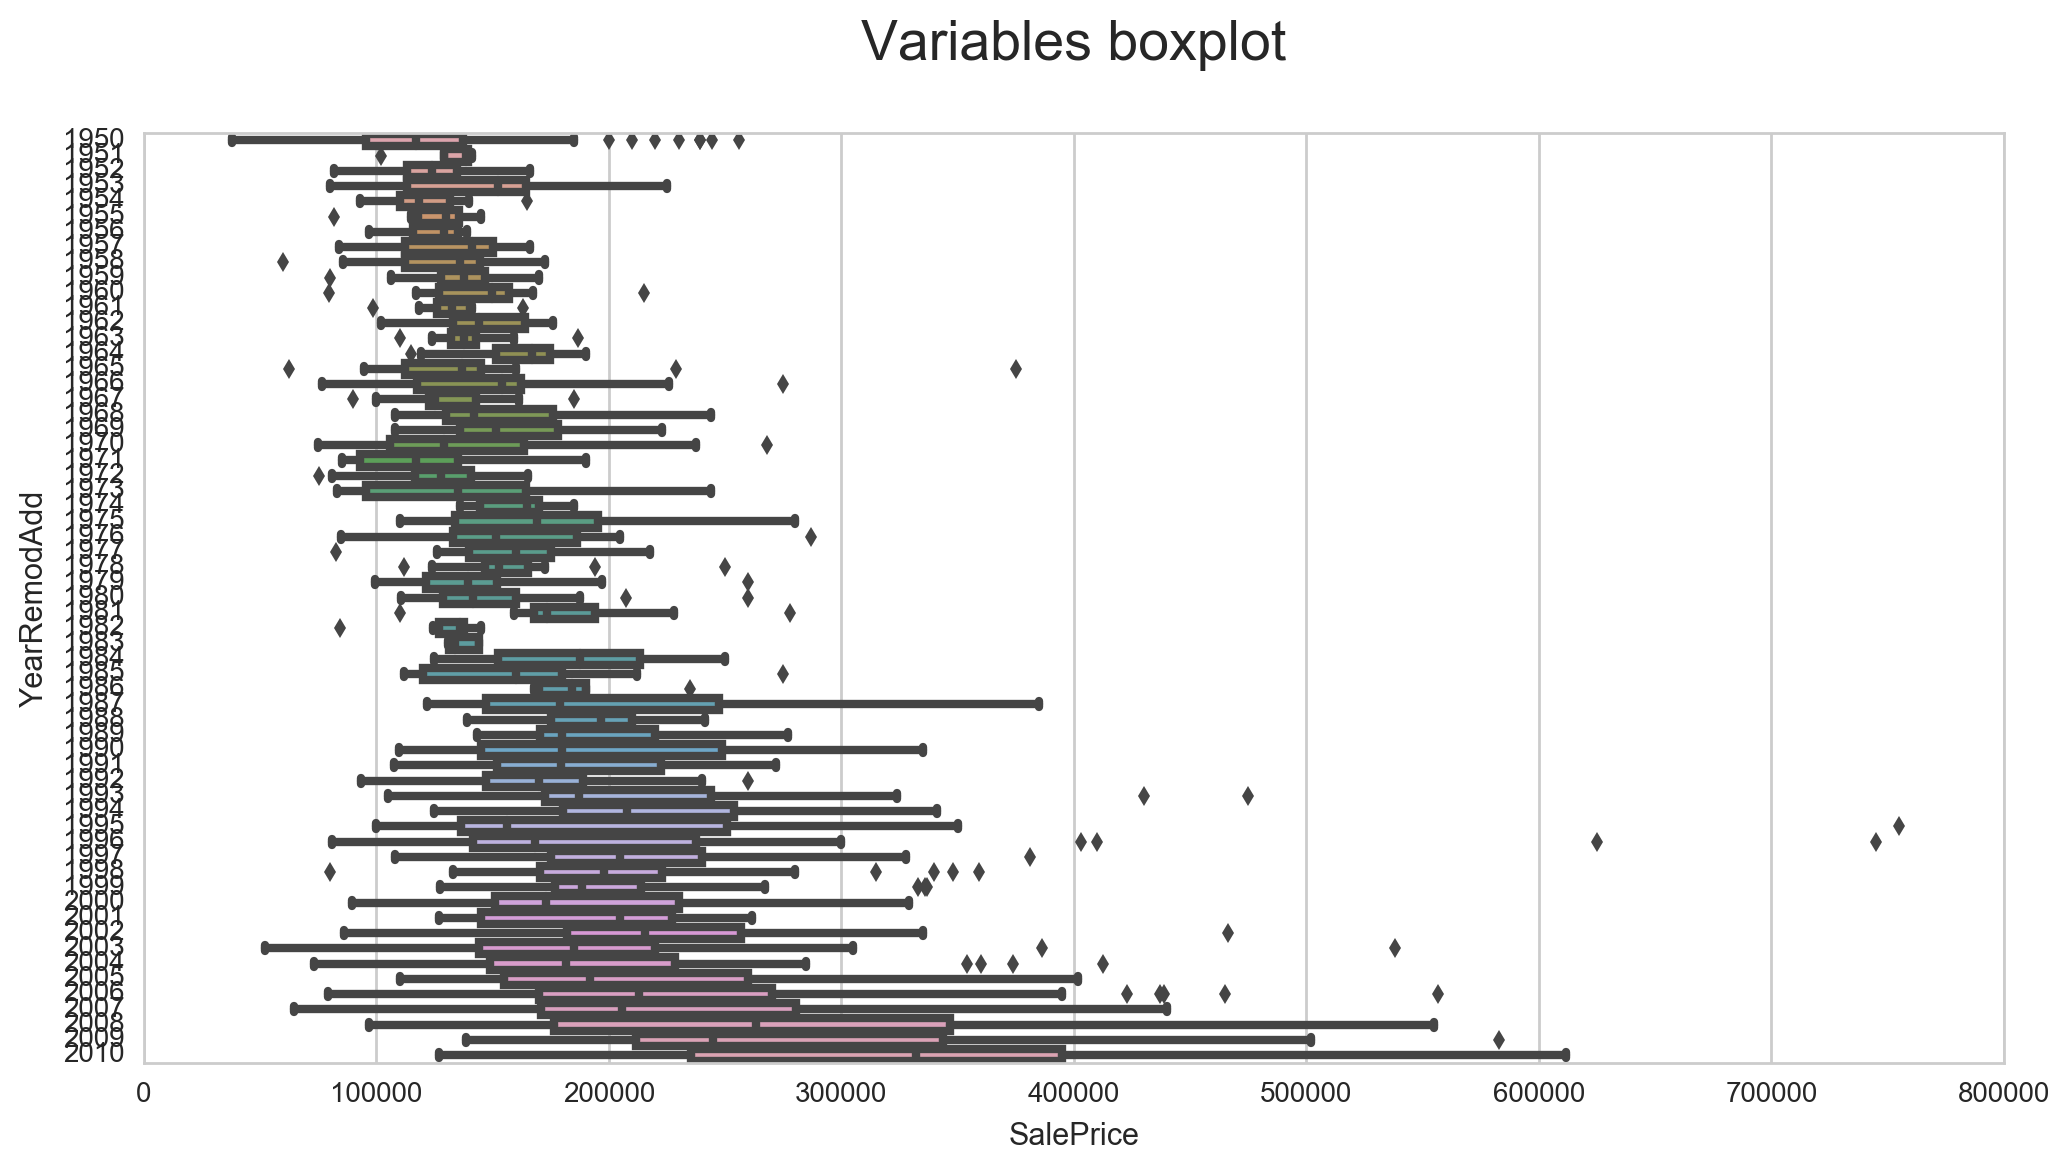

In [163]:
fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(x=house_updated['SalePrice'], y=house_updated['YearRemodAdd'], orient='h', fliersize=5, linewidth=3, saturation=0.5)

ax.set_title('Variables boxplot\n', fontsize=20)
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 7. Univariate regression predicting price with statsmodels

---

### 7.1 Build a linear regression with statsmodels predicting sales price from total living area sq ft.

Print the results of the regression.


In [164]:
# data modules
import numpy as np
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats/Regresions Packages
from sklearn import linear_model
from sklearn.metrics import mean_squared_error


# make sure charts appear in the notebook:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [165]:
house_updated.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,House_Age
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,5
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,31
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,7
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,91
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,8


In [166]:
def calc_beta_one(x, y):
    mean_y = np.mean(y)
    mean_x = np.mean(x)
    
    numerator = np.sum((y - mean_y)*(x - mean_x))
    denominator = np.sum((x - mean_x)**2)
    
    return numerator/denominator

    
def calc_beta_zero(x, y, b1):
    
    mean_y = np.mean(y)
    mean_x = np.mean(x)
    
    return mean_y - b1*mean_x

def calculate_yhat(x, b0, b1):
    return b0 + b1*x

In [167]:
lm = linear_model.LinearRegression() 

y = house_updated['SalePrice']
X = house_updated['GrLivArea']

model = sm.OLS(y, X)
results = model.fit()
predictions = results.predict(X)

b1 = calc_beta_one(X, y)
b0 = calc_beta_zero(X, y, b1)

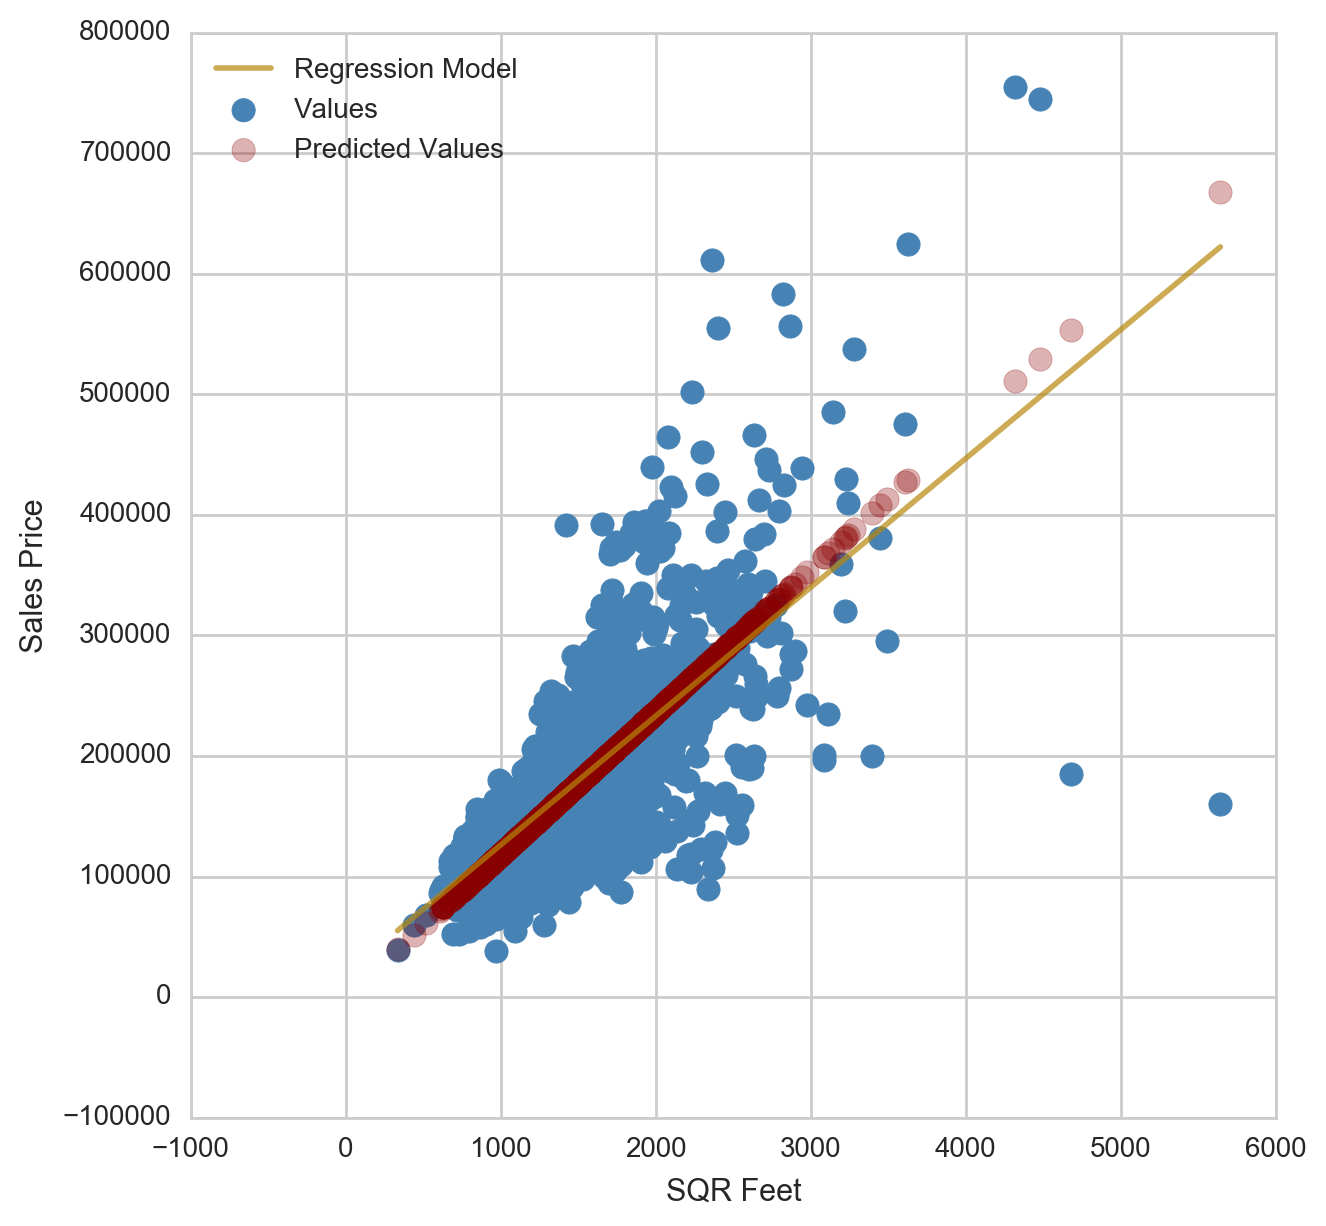

In [168]:
fig = plt.figure(figsize=(7,7))
ax = fig.gca()
    
ax.scatter(X, y, color='steelblue', s=70, label='Values')
ax.scatter(X, predictions, color='darkred', s=70, alpha=0.3, label='Predicted Values')
    
min_x, max_x = np.min(X), np.max(X)
min_yhat = calculate_yhat(min_x, b0, b1)
max_yhat = calculate_yhat(max_x, b0, b1)
    
ax.plot([min_x, max_x], [min_yhat, max_yhat], color='darkgoldenrod',
            linewidth=2.0, alpha=0.7, label ='Regression Model')
 
plt.legend(loc='upper left')

plt.xlabel("SQR Feet")
plt.ylabel("Sales Price")
    
plt.show()

### 7.2 Explain the regression results

What do each of these things represent/mean?

1. The intercept coefficient.
2. The coefficient on GrLivArea.
3. The R-squared value.
4. The p-value for coefficients (P>|t|)

In [169]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                 1.656e+04
Date:                Sun, 04 Dec 2016   Prob (F-statistic):               0.00
Time:                        22:43:42   Log-Likelihood:                -17916.
No. Observations:                1450   AIC:                         3.583e+04
Df Residuals:                    1449   BIC:                         3.584e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
GrLivArea    118.3181      0.919    128.684      0.000       116.514   120.122
==============================================================================
Omnibus:                      244.462   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4581.487
Skew:                          -0.053   Prob(JB):                         0.00
Kurtosis:                      11.707   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 8. Multivariate regression predicting price with sklearn

---

### 8.1 Build an sklearn linear regression predicting sale price 

Use all of your continuous measures as predictors (no categorical yet).

In [170]:
house_updated.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,House_Age
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,5
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,31
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,7
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,91
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,8


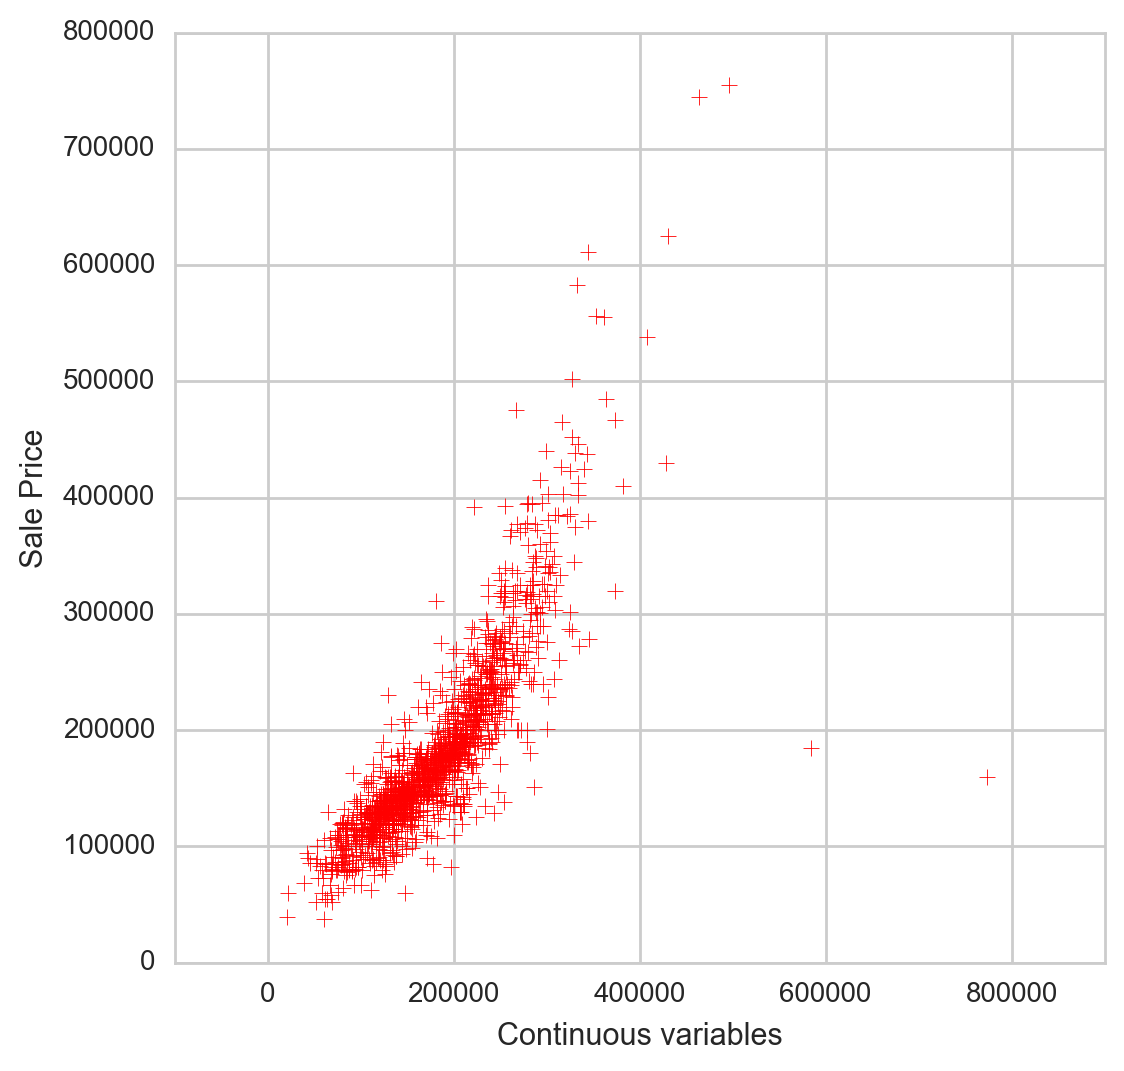

In [171]:
lm = linear_model.LinearRegression()

y = house_updated['SalePrice']
X = house_updated[['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtHalfBath', 'BsmtUnfSF', 
           'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF', 
           'PoolArea', 'MiscVal', 'GrLivArea', 'House_Age']]

model = lm.fit(X, y)
predictions = model.predict(X)
score = model.score(X, y)

plt.figure(figsize=(6,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Continuous variables")
plt.ylabel("Sale Price")
plt.show()

### 8.2 Calculate the $R^2$ of your model.

In [172]:
score

0.70868085240723511

### 8.3 Plot the residuals against the true values.

In [173]:
residuals = y - predictions

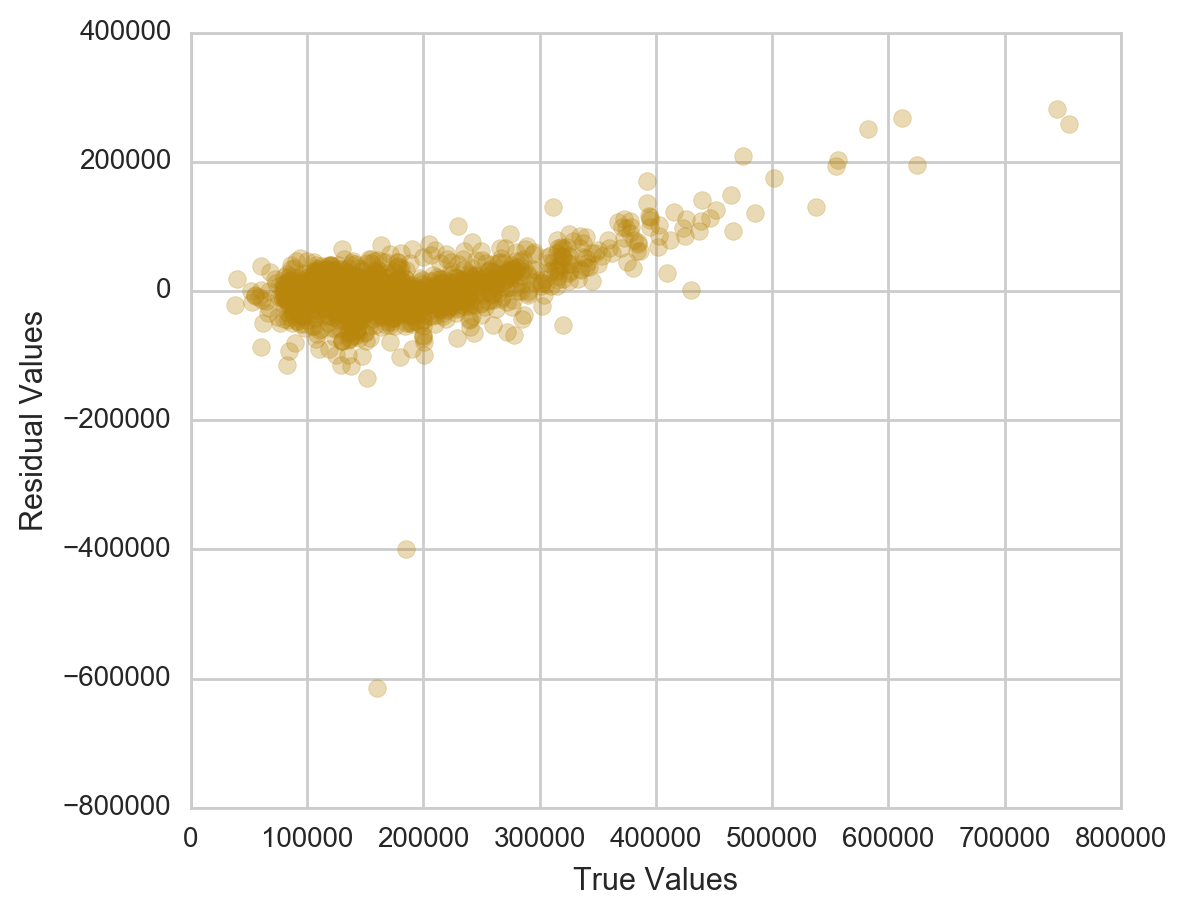

In [174]:
Fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(y, residuals,  s=40, color='darkgoldenrod', alpha=0.3)
ax.set_xlabel('True Values')
ax.set_ylabel('Residual Values')

plt.show()

### 8.4 Plot a histogram of the residuals.

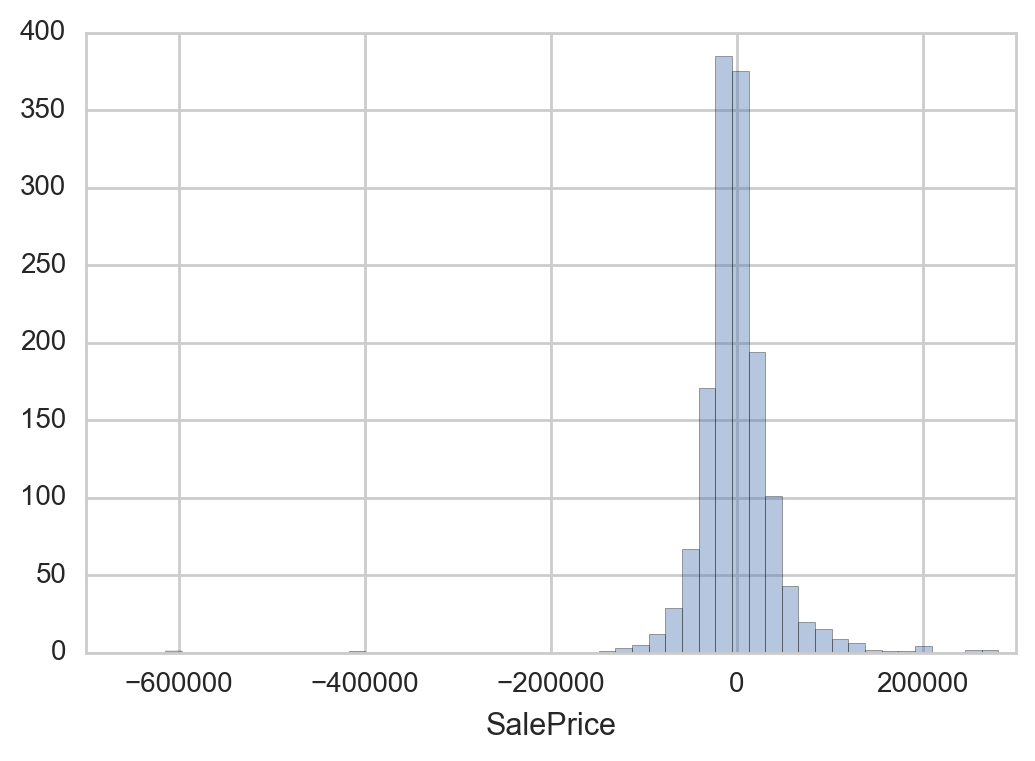

In [175]:
sns.distplot(residuals, bins=50, kde = False)

### 8.5 Make a plot to show the strength of the different coefficients.

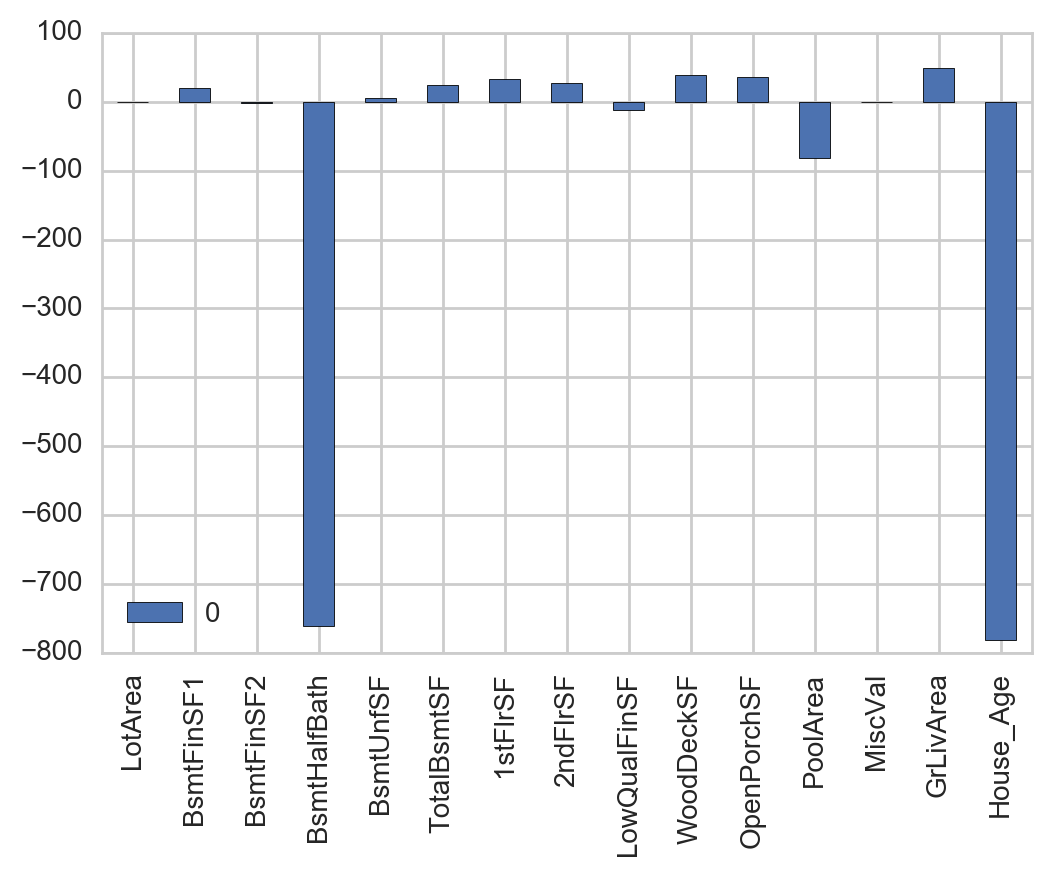

In [176]:
coefs = pd.DataFrame(model.coef_)
coefs.index = X.columns
coefs.plot(kind="bar")

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 9. Create a predictor matrix using all viable predictors available to you

---

You will need to dummy code the categorical variables. This is done most easily using patsy by constructing a formula string to make the matrix, but can be done with sklearn functions or manually as well. 

Recall that the `C(variable)` syntax in patsy formulas will take the column named `'variable'` and make it into dummy coded columns. You may also need to rename columns, patsy has trouble with column names that start with numbers.

Lastly, remember that you may need to convert your target `y` from a matrix to a vector (patsy outputs it as 2D rather than 1D, which skearn may have trouble with.)

In [177]:
import patsy
from patsy import dmatrix, demo_data, ContrastMatrix, Poly
import pandas as pd
house_updated.head()
#house_updated.shape

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,House_Age
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,5
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,31
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,7
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,91
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,8


In [178]:
# temp = house_updated['SalePrice']
# house_updated.drop(labels=['SalePrice'], axis=1,inplace = True)
# house_updated.insert(1, 'SalePrice', temp)
# house_updated

#house_updated.drop(labels=['Id'], axis=1, inplace=True)
#house_updated.drop(labels=['HouseStyle'], axis=1, inplace=True)
#house_updated.drop(labels=['3SsnPorch'], axis=1, inplace=True)
#house_updated.drop(labels=['1stFlrSF'], axis=1, inplace=True)
#house_updated.drop(labels=['2ndFlrSF'], axis=1, inplace=True)

In [179]:
#house_new = pd.get_dummies(house_updated)

In [180]:
# dummy  =  "SalePrice ~ LotArea + OverallQual + OverallCond + BsmtFinSF1 + BsmtFinSF2 + BsmtHalfBath + \
# BsmtUnfSF + TotalBsmtSF + LowQualFinSF + TotRmsAbvGrd + WoodDeckSF +OpenPorchSF + PoolArea + \
# MiscVal + GrLivArea + Age + MSZoning + Street +LotShape + LandContour + Utilities + LotConfig + LandSlope + \
# Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + \
# ExterQual + ExterCond + Foundation + Heating + HeatingQC + CentralAir + \
# KitchenQual + Functional + PavedDrive + SaleType + SaleCondition - 1"

# y, X     =  patsy.dmatrices(dummy, data=house, return_type="dataframe")

In [181]:
house_updated.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,House_Age
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,5
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,31
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,7
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,91
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,8


In [182]:
formula  =  "SalePrice ~ LotArea + OverallQual + OverallCond + BsmtFinSF1 + BsmtFinSF2 + BsmtHalfBath + \
BsmtUnfSF + TotalBsmtSF + LowQualFinSF + TotRmsAbvGrd + WoodDeckSF +OpenPorchSF + PoolArea + \
MiscVal + GrLivArea + MSZoning + Street +LotShape + LandContour + Utilities + LotConfig + LandSlope + \
Neighborhood + Condition1 + Condition2 + BldgType + HouseStyle + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + \
MasVnrType + ExterQual + ExterCond + Foundation+ BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinType2 + \
Heating + HeatingQC + CentralAir + Electrical + KitchenQual + Functional + FireplaceQu + GarageType + GarageFinish +\
GarageQual + GarageCond + PavedDrive + SaleType + SaleCondition - 1"

y, X = patsy.dmatrices(formula, data=house, return_type="dataframe")

In [183]:
B.head()

NameError: name 'B' is not defined

In [ ]:
#target = 'SalePrice'

#non_target_cols = [c for c in house_updated.columns if c != target]

# Use some string adding and joining to make the simple model formula:
#formula = target + ' ~ ' + ' + '.join(non_target_cols) + ' - 1'
#print formula

# formula_updated = "SalePrice ~ MSSubClass + MSZoning + LotArea + Street + Alley + LotShape + LandContour + Utilities + LotConfig + LandSlope + Neighborhood + Condition1 + Condition2 + BldgType + YearBuilt + YearRemodAdd + RoofStyle + RoofMatl + Exterior1st + Exterior2nd + ExterQual + ExterCond + Foundation + BsmtQual + BsmtCond + BsmtExposure + BsmtFinType1 + BsmtFinSF1 + BsmtFinType2 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + Heating + HeatingQC + CentralAir + LowQualFinSF + GrLivArea + BsmtFullBath + BsmtHalfBath + FullBath + HalfBath + KitchenQual + Functional + Fireplaces + FireplaceQu + GarageType + GarageFinish + GarageCars + GarageArea + GarageQual + GarageCond + PavedDrive + WoodDeckSF + OpenPorchSF + EnclosedPorch + ScreenPorch + PoolArea + PoolQC + Fence + MiscFeature + MiscVal + MoSold + YrSold + SaleType + SaleCondition + House_Age - 1"

# y, X = patsy.dmatrices(formula_updated, data=house_updated, return_type="dataframe")

### 9.2 Fit a linear regression using all of the predictors and score it.

In [ ]:
model = lm.fit(X, y)
predictions = model.predict(X)
score = model.score(X, y)

plt.figure(figsize=(6,6))
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Variables")
plt.ylabel("Sale Price")
plt.show()

### 9.3 Explain why this model and associated $R^2$ score may not be as "good" as they seem.

In [ ]:
score
#It's over fitting the data beucase there are so many variables

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 10. Cross-validate the model

---

Use 20 folds and calculate the average $R^2$ of your model that has all of the predictors in it.

In [ ]:
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics

scores = cross_val_score(model, X, y, cv=20)
print "Cross-validated scores:", scores

predictions = cross_val_predict(model, X, y, cv=20)
plt.scatter(y, predictions)


accuracy = metrics.r2_score(y, predictions)


print "Cross-Predicted Accuracy:", accuracy

### 10.2 What does the cross-validated average $R^2$ tell you?

In [ ]:
#That across our various k-folds, we have a failry accurate model (because it's not neagative). However, the R2 shows
#the data is fairly colinear and there is a lot of noise from the variables we've chosen

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 10.3 When can you have a negative $R^2$ score? Explain what it means.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 11. Construct a Lasso regression and find the optimal regularization strength

---

Now you'll fit a Lasso regression using again the full predictor matrix. 

### 11.1 Using either `LassoCV` or `GridSearchCV` with `Lasso`, find the optimal regularization strength.

You are finding the best `alpha` to use with this data. For `LassoCV` you can use the `n_alphas` parameter to specify how many possible alphas you want the model to search over. With `GridSearchCV` you will have to give it a vector of the alphas you want to try.

Note that in both cases you will need to specify the number of cross-validation folds `cv`. 10 is generally a good number of folds. 

**Remember that you must standardize your predictor matrix when using regularization!**

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xn = ss.fit_transform(X)
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xn, y)

print optimal_lasso.alpha_

### 11.2 Construct a `Lasso` model with the optimal `alpha` and cross-validate the $R^2$.

In [ ]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xn, y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 11.3 Explain the effect of the Lasso regularization and why it can be useful.

### 11.4 Print out the variables with non-zero Lasso coefficients (with the coefficient).

How many variables remain? 

Tell a (brief) story about what is important for estimating price based on the variables and their coefficients. Just pick out the things most interesting to you.

In [ ]:
lasso.fit(Xn, y)
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

#The ability to predcit the price of the house, these are the variables that we can look at to see how the correlated
#they are to the price. Living are, quality, the neighrborhood, kitchen quality, bedroom quality. This all makes sense
#as they would correlate to a high Sales Price

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 12. Construct a Ridge regression and find the optimal regularization strength

---

### 12.1 Create a predictor matrix of only variables related to sq. ft.

**Remember that you must standardize your predictor matrix before using Ridge regularization.**

In [185]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xn = ss.fit_transform(X)

In [186]:
variables = "SalePrice ~  BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + LowQualFinSF + WoodDeckSF + OpenPorchSF + GrLivArea - 1"

In [187]:
y, X = patsy.dmatrices(variables, data=house, return_type="dataframe")

### 12.2 Plot a correlation matrix of your predictors. Why might Ridge be useful here?

In [ ]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(6,6))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True, annot_kws={"size": 6})

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=6, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=6, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
correlation_heat_map(X)

#There isn't a lot of correlation and coliniarity between the variables so the ridge regression coefficients will
#help alleviate that uncertanty

### 12.3 Find the optimal Ridge `alpha` using either `RidgeCV` or a combination of `GridSearchCV` and `Ridge`.



In [188]:
ss = StandardScaler()
Xn = ss.fit_transform(X)
ridge_alphas = np.logspace(0,5,200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xn,y)
print optimal_ridge.alpha_

64.4236350872


### 12.4 Compare the cross-validated $R^2$ score for a standard Linear Regression and your Ridge regression

In [193]:
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Xn, y, cv=10)

ridge_scores
np.mean(ridge_scores)

0.6264633603773393

In [195]:
model = lm.fit(X, y)
predictions = model.predict(X)
score = model.score(X, y)
score

0.63877258424162997

In [196]:
print 'Linear Regression R^2:', score
print 'Ridge R^2:', np.mean(ridge_scores)

Linear Regression R^2: 0.638772584242
Ridge R^2: 0.626463360377


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 13. Explain the difference between Ridge and Lasso regularization

---

- When are good scenarios to use each? What problems do they address?
- Why do they have the effects they do on coefficients?
- What is their effect on bias and variance?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 14. Gridsearch an optimal `ElasticNet` regression.

---

On the full predictor matrix, search for the optimal hyperparameters for an Elastic Net regression. Remember that the Elastic net is a mixture of the Ridge and Lasso, and has both an `alpha` parameter to regularize as well as an `l1_ratio`, which is the balance of Lasso vs. Ridge.

How does the ElasticNet compare to the Lasso on the dataset? What does the `l1_ratio` tell you about the balance of Ridge vs. Lasso in your model?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 15. Further fine-tune the model to predict price

---

Your goal is to create the model with the best predictive power.

You can use as much feature engineering and transformation of variables that you want, but please limit yourself to using the regression models we have covered in class thus far. When we cover models like Random Forests and Gradient Boosted Trees we will return to this dataset and see how they compare to the regression models.

For those that tackle this problem, you will have a chance to show what you did and compare to what your other classmates came up with during class (if you want). **Feel free to collaborate with your classmates on improving the model!**